# Classifying Breast Cancer
## Breast Cancer Wisconsin (Diagnostic) Data Set

From: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/

References:
- [Diagnosing breast cancer with AI // Coding for Medicine #3](https://www.youtube.com/watch?v=c8s5GKRrenY&t=1482s)
- [A Gentle Introduction to tidymodels](https://rviews.rstudio.com/2019/06/19/a-gentle-intro-to-tidymodels/)'
- [Blog Post 4 - An Introduction To Tidymodels](https://rstudio-pubs-static.s3.amazonaws.com/606415_29e3fe510fd94f9da60b19e2abf07397.html)
- [Get started with tidymodels and classification of penguin data](https://www.youtube.com/watch?v=z57i2GVcdww&t=115s)

In [1]:
library(tidymodels)
library(repr)

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

-- Attaching packages ------------------------------------------------------------------------------ tidymodels 0.1.3 --

v broom        0.7.6      v recipes      0.1.16
v dials        0.0.9      v rsample      0.1.0 
v dplyr        1.0.6      v tibble       3.1.2 
v ggplot2      3.3.3      v tidyr        1.1.3 
v infer        0.5.4      v tune         0.1.5 
v modeldata    0.1.0      v workflows    0.2.2 
v parsnip      0.1.6      v workflowsets 0.0.2 
v purrr        0.3.4      v yardstick    0.0.8 

-- Conflicts --------------------------------------------------------------------------------- tidymodels_conflicts() --
x purrr::discard() masks scales::discard()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
x recipes::step()  masks stats::step()
* Use tidymodels_prefer() to resolve common conflicts.



In [2]:
data <- readr::read_csv("wisconsin-cancer-data.csv")

head(data)

Warning message:
"Missing column names filled in: 'X33' [33]"

-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  diagnosis = col_character(),
  X33 = col_character()
)
i Use `spec()` for the full column specifications.


Warning message:
"569 parsing failures.
row col   expected     actual                        file
  1  -- 33 columns 32 columns 'wisconsin-cancer-data.csv'
  2  -- 33 columns 32 columns 'wisconsin-cancer-data.csv'
  3  -- 33 columns 32 columns 'wisconsin-cancer-data.csv'
  4  -- 33 columns 32 columns 'wisconsin-cancer-data.csv'
  5  -- 33 columns 32 columns 'wisconsin-cancer-data.csv'
... ... .......... .......... ...........................
See problems(...) for more details.
"


id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,X33
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NA
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NA
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NA
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NA
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NA
843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NA


# Exploratory Data Analysis

In [3]:
skimr::skim(data)

-- Data Summary ------------------------
                           Values
Name                       data  
Number of rows             569   
Number of columns          33    
_______________________          
Column type frequency:           
  character                2     
  numeric                  31    
________________________         
Group variables            None  

-- Variable type: character ----------------------------------------------------
# A tibble: 2 x 8
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
* <chr>             <int>         <dbl> <int> <int> <int>    <int>      <int>
1 diagnosis             0             1     1     1     0        2          0
2 X33                 569             0    NA    NA     0        0          0

-- Variable type: numeric ------------------------------------------------------
# A tibble: 31 x 11
   skim_variable           n_missing complete_rate    mean      sd          p0
 * <chr>                  

In [4]:
data_long <- data %>%
    select(-X33) %>%
    gather(variable, measurement, radius_mean:fractal_dimension_worst, factor_key=TRUE)

head(data_long)

id,diagnosis,variable,measurement
<dbl>,<chr>,<fct>,<dbl>
842302,M,radius_mean,17.99
842517,M,radius_mean,20.57
84300903,M,radius_mean,19.69
84348301,M,radius_mean,11.42
84358402,M,radius_mean,20.29
843786,M,radius_mean,12.45


## Mean Data

In [5]:
data_mean <- data_long %>% 
    filter(grepl('_mean', variable)) %>%
    mutate(diagnosis = factor(diagnosis, levels = c("M", "B")))

data_mean %>%
    group_by(variable) %>%
    summarize(median = median(measurement)) %>%
    arrange(desc(median))

variable,median
<fct>,<dbl>
area_mean,551.10000
perimeter_mean,86.24000
texture_mean,18.84000
radius_mean,13.37000
symmetry_mean,0.17920
smoothness_mean,0.09587
compactness_mean,0.09263
concavity_mean,0.06154
fractal_dimension_mean,0.06154


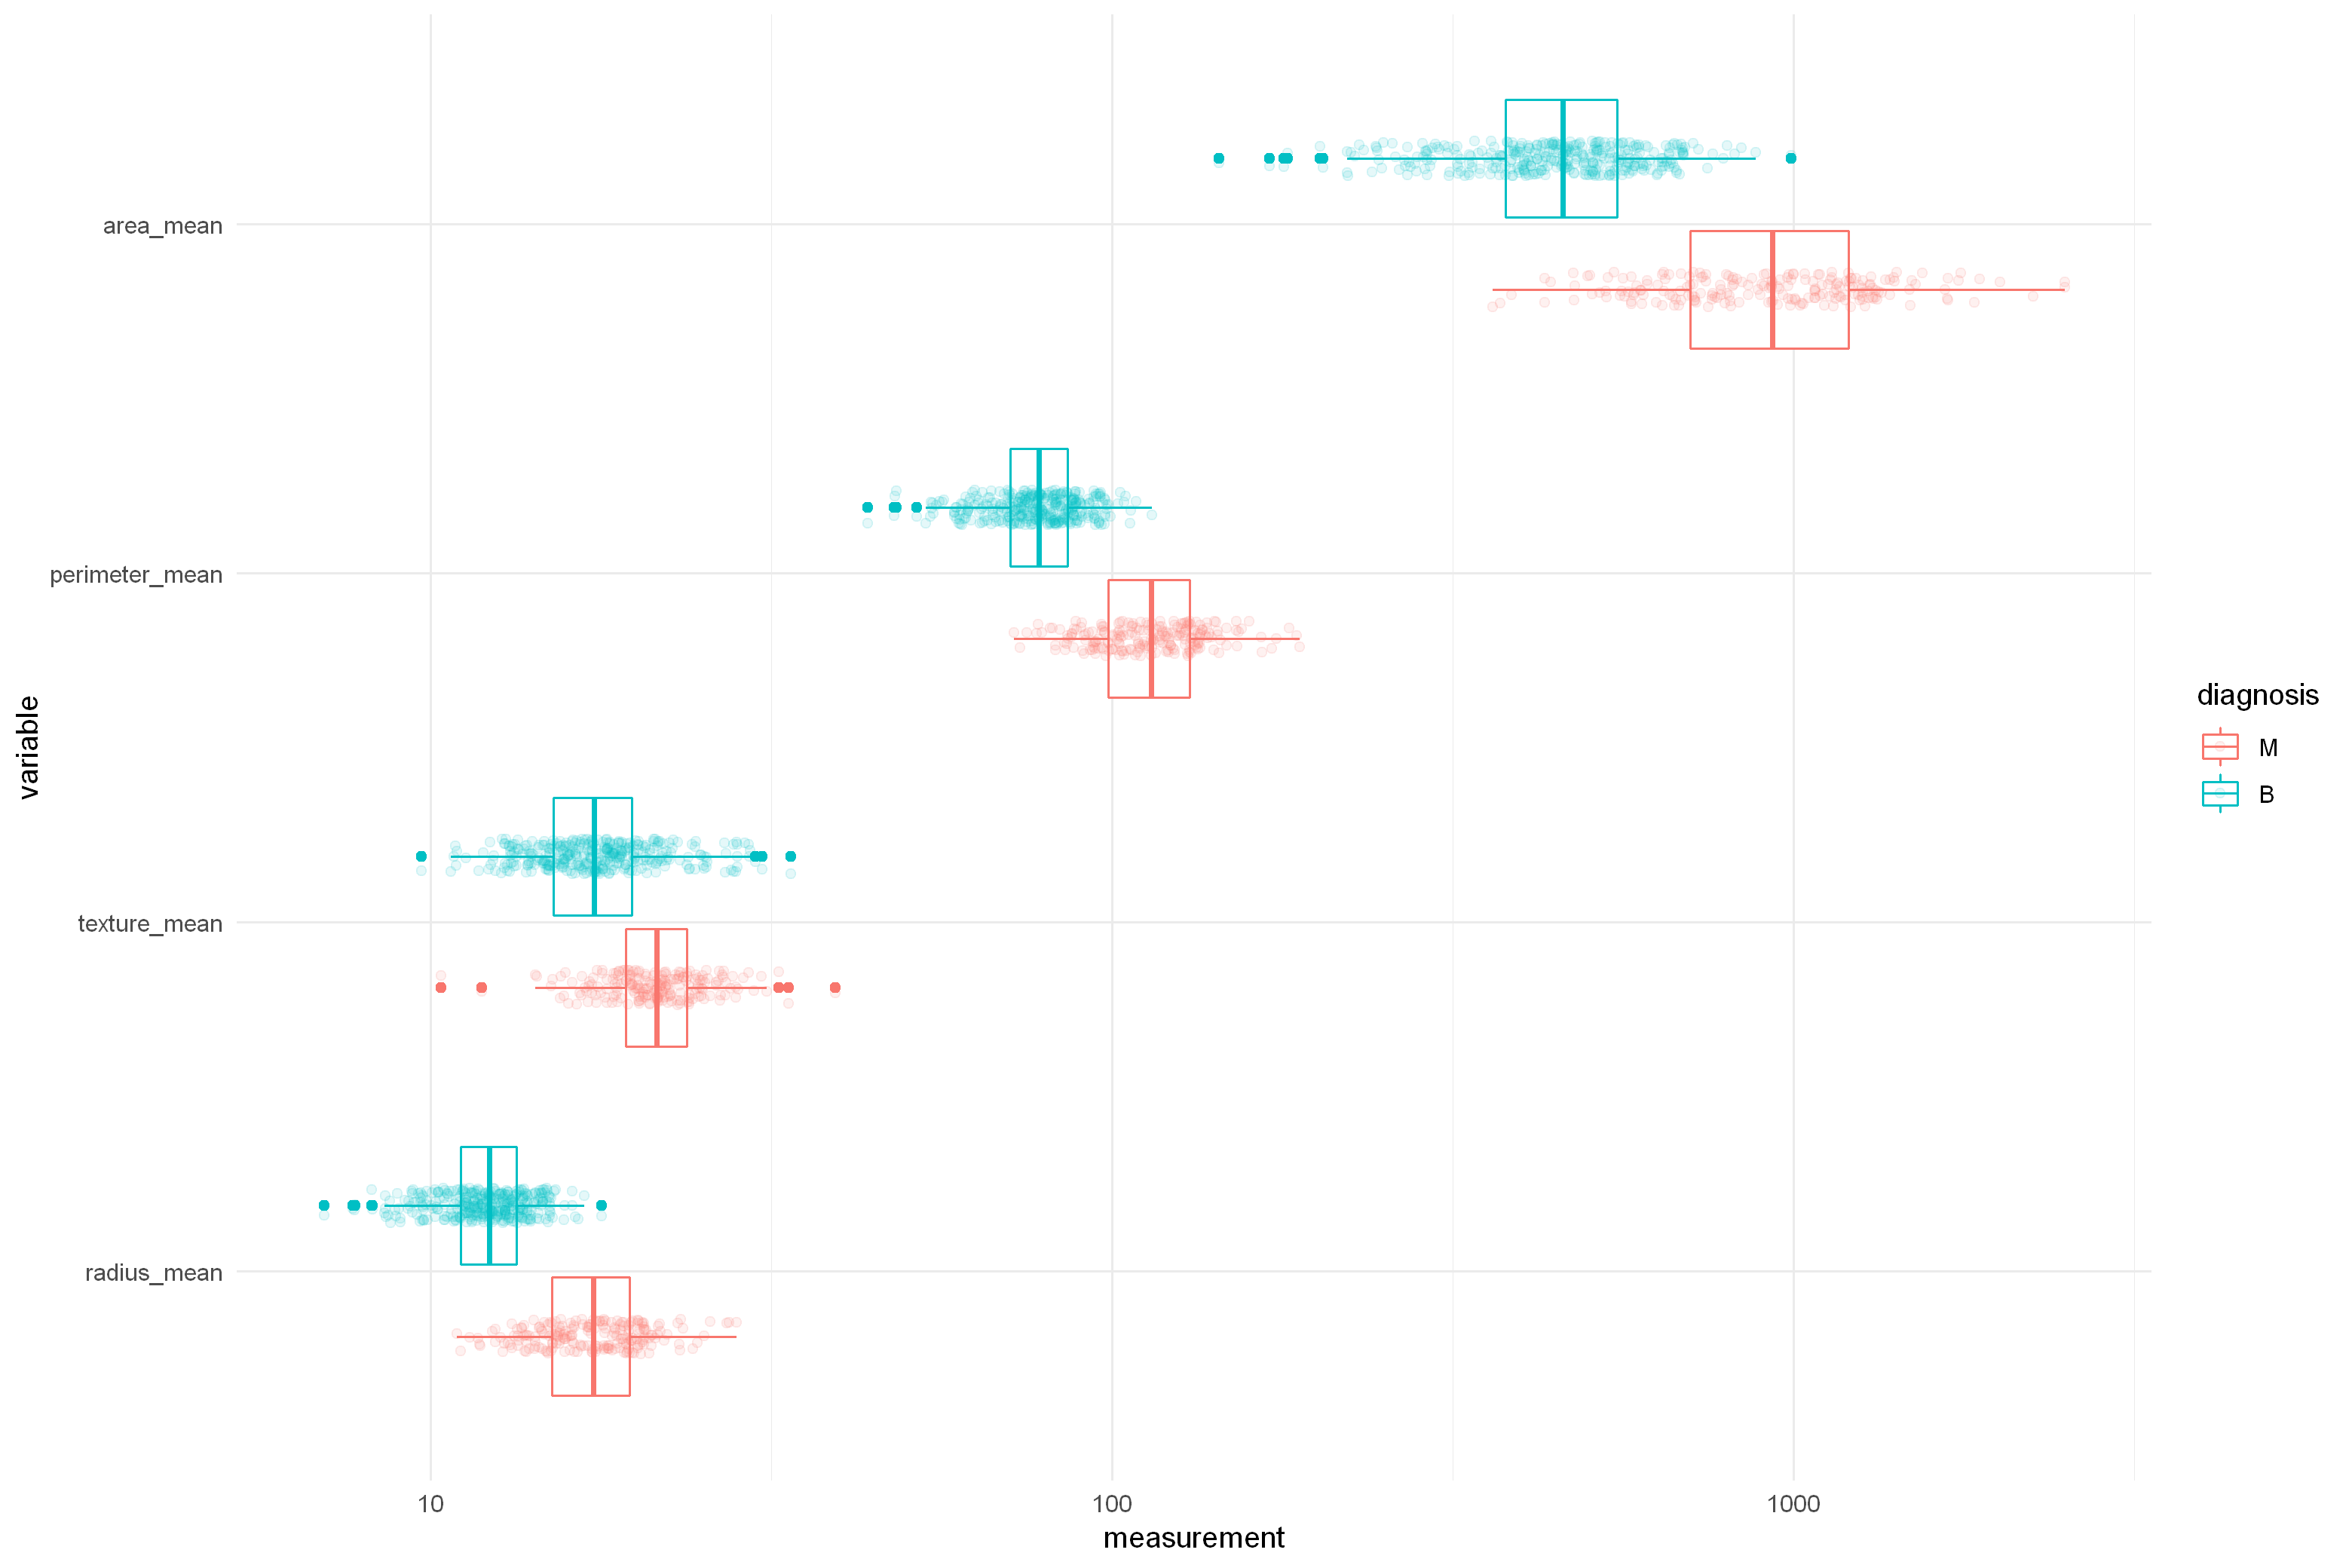

In [6]:
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res=260)

high_median <- c("area_mean", "perimeter_mean", "texture_mean", "radius_mean")

data_mean %>%
    filter(variable %in% high_median) %>%
    ggplot(aes(x = variable, y = measurement, color = diagnosis)) + 
        geom_boxplot() + 
        geom_point(position = position_jitterdodge(jitter.width = 0.2), alpha = 0.1) + 
        theme_minimal() +
        scale_y_log10() + 
        coord_flip()

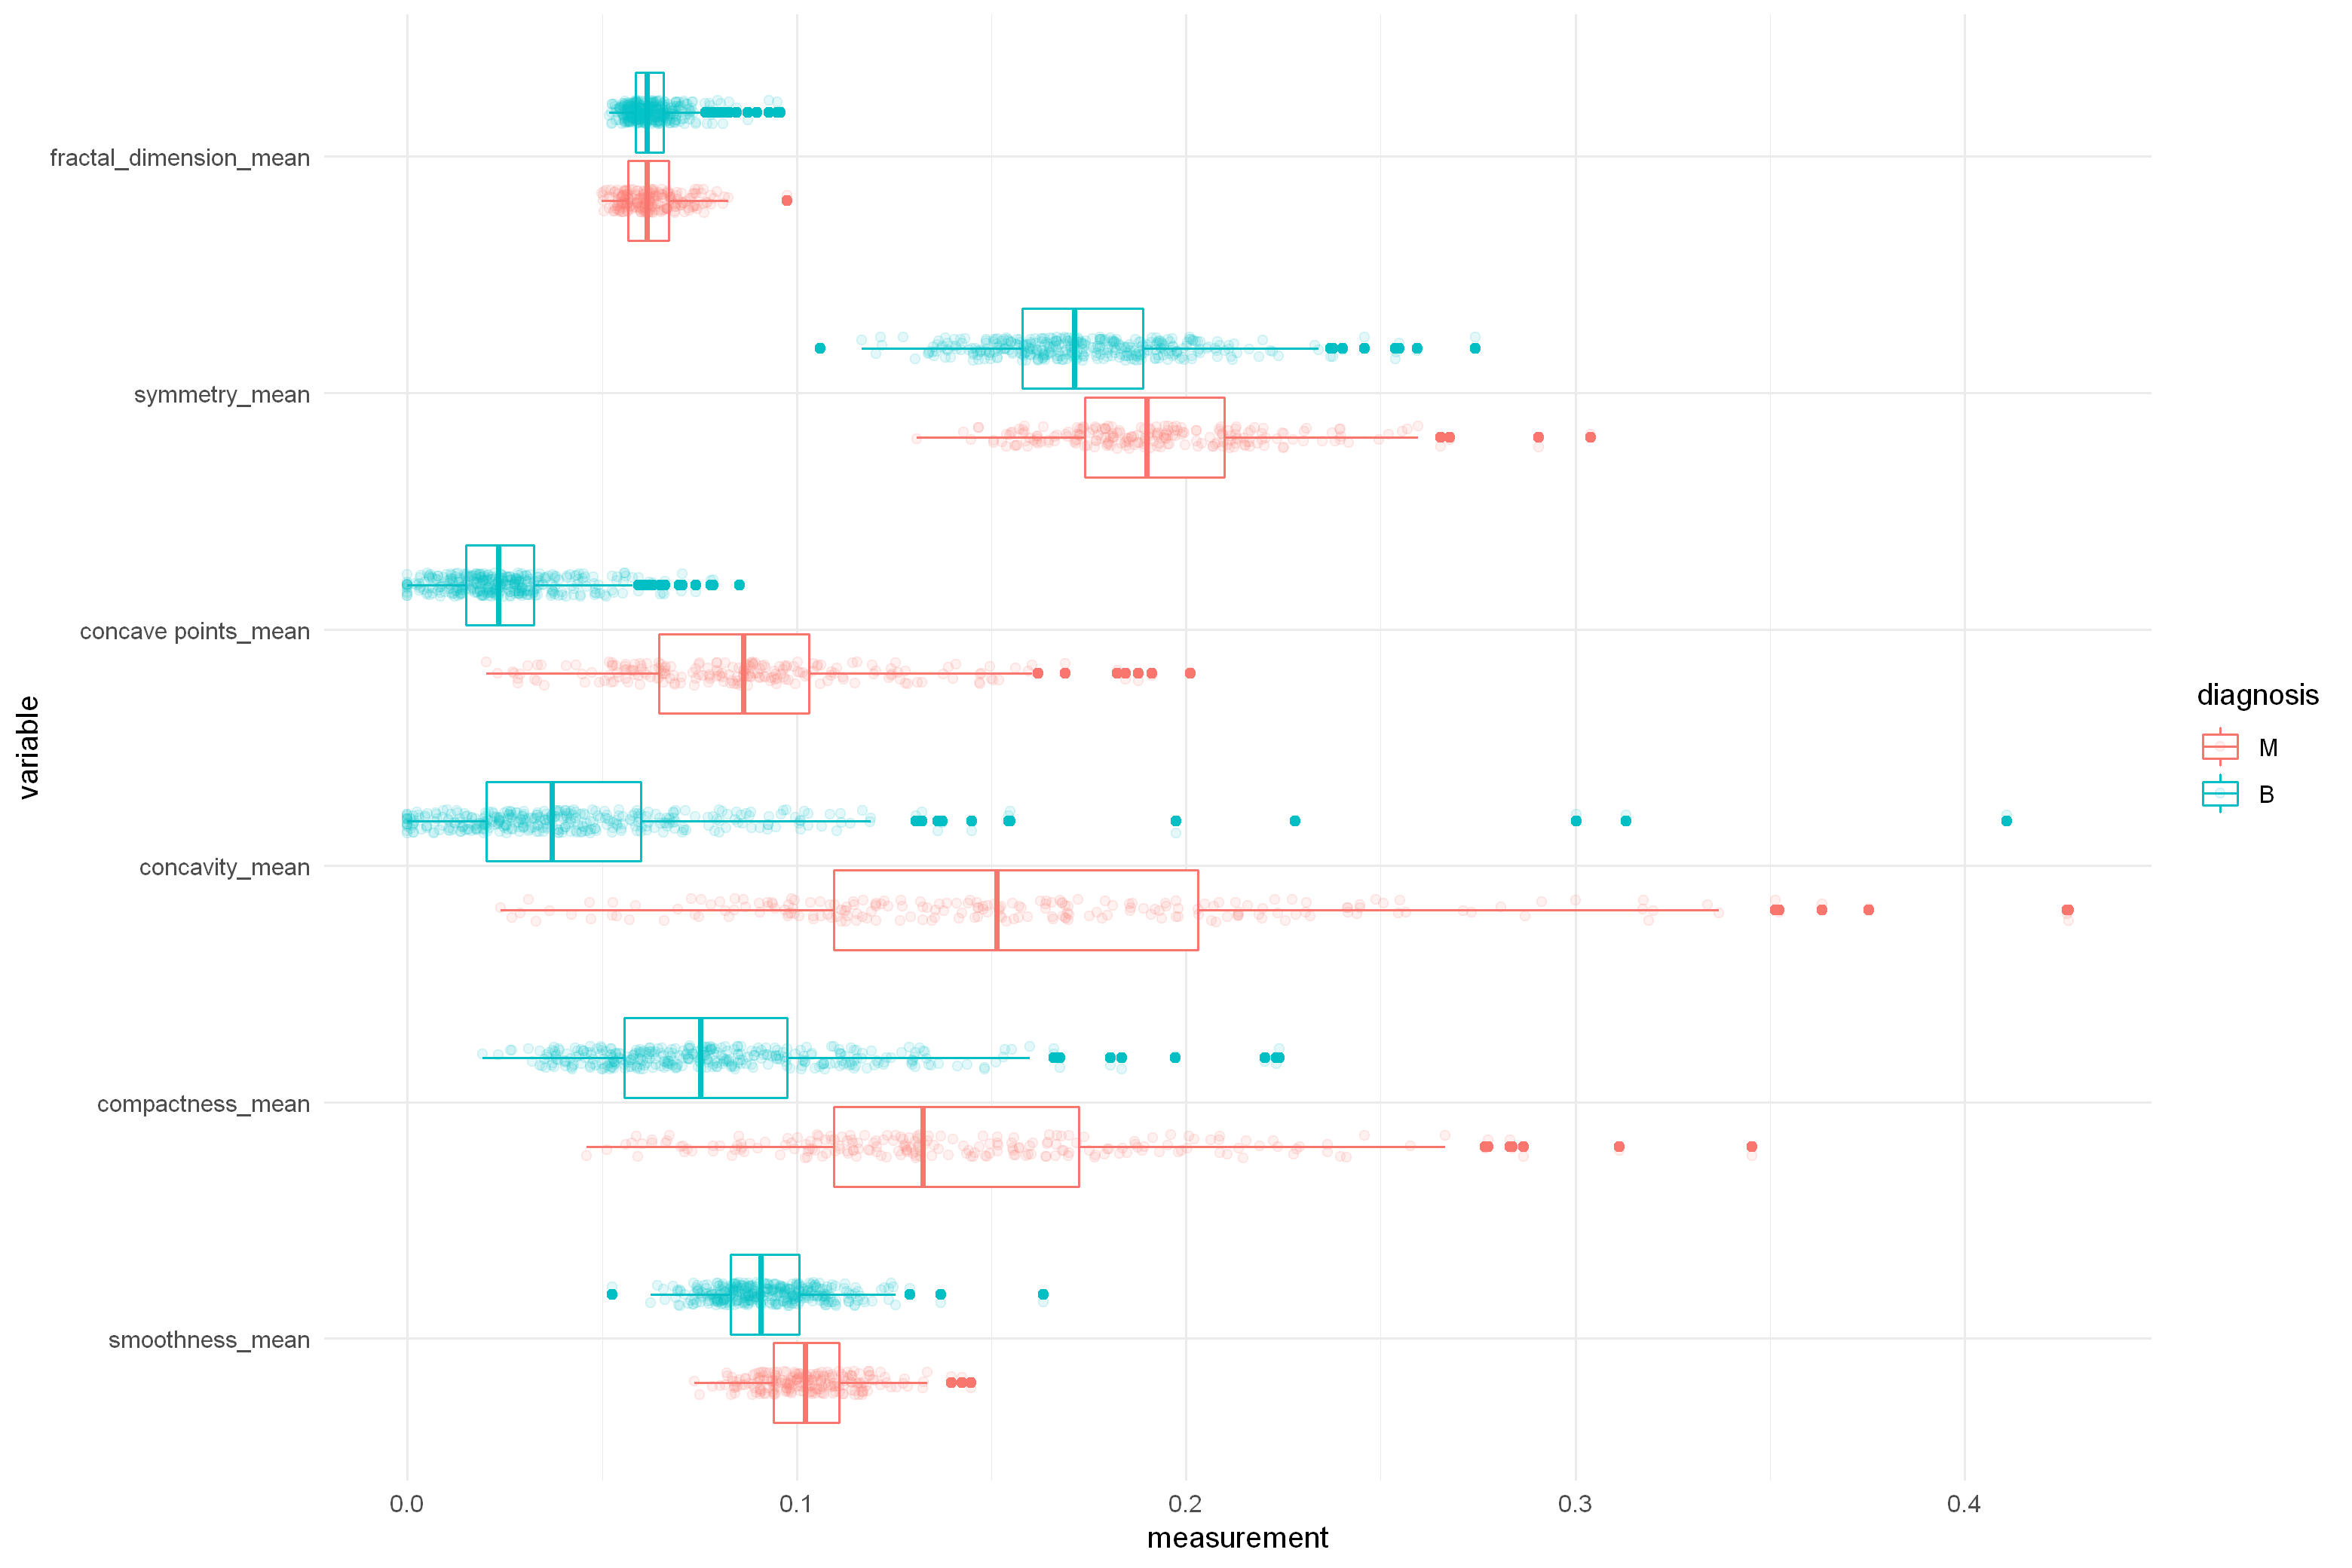

In [7]:
data_mean %>%
    filter(!variable %in% high_median) %>%
    ggplot(aes(x = variable, y = measurement, color = diagnosis)) + 
        geom_boxplot() + 
        geom_point(position = position_jitterdodge(jitter.width = 0.2), alpha = 0.1) + 
        theme_minimal() +
        coord_flip()

## Standard Error Data

In [8]:
data_se <- data_long %>% 
    filter(grepl('_se', variable)) %>%
    mutate(diagnosis = factor(diagnosis, levels = c("M", "B")))

data_se %>%
    group_by(variable) %>%
    summarize(median = median(measurement)) %>%
    arrange(desc(median))

variable,median
<fct>,<dbl>
area_se,24.530000
perimeter_se,2.287000
texture_se,1.108000
radius_se,0.324200
concavity_se,0.025890
compactness_se,0.020450
symmetry_se,0.018730
concave points_se,0.010930
smoothness_se,0.006380


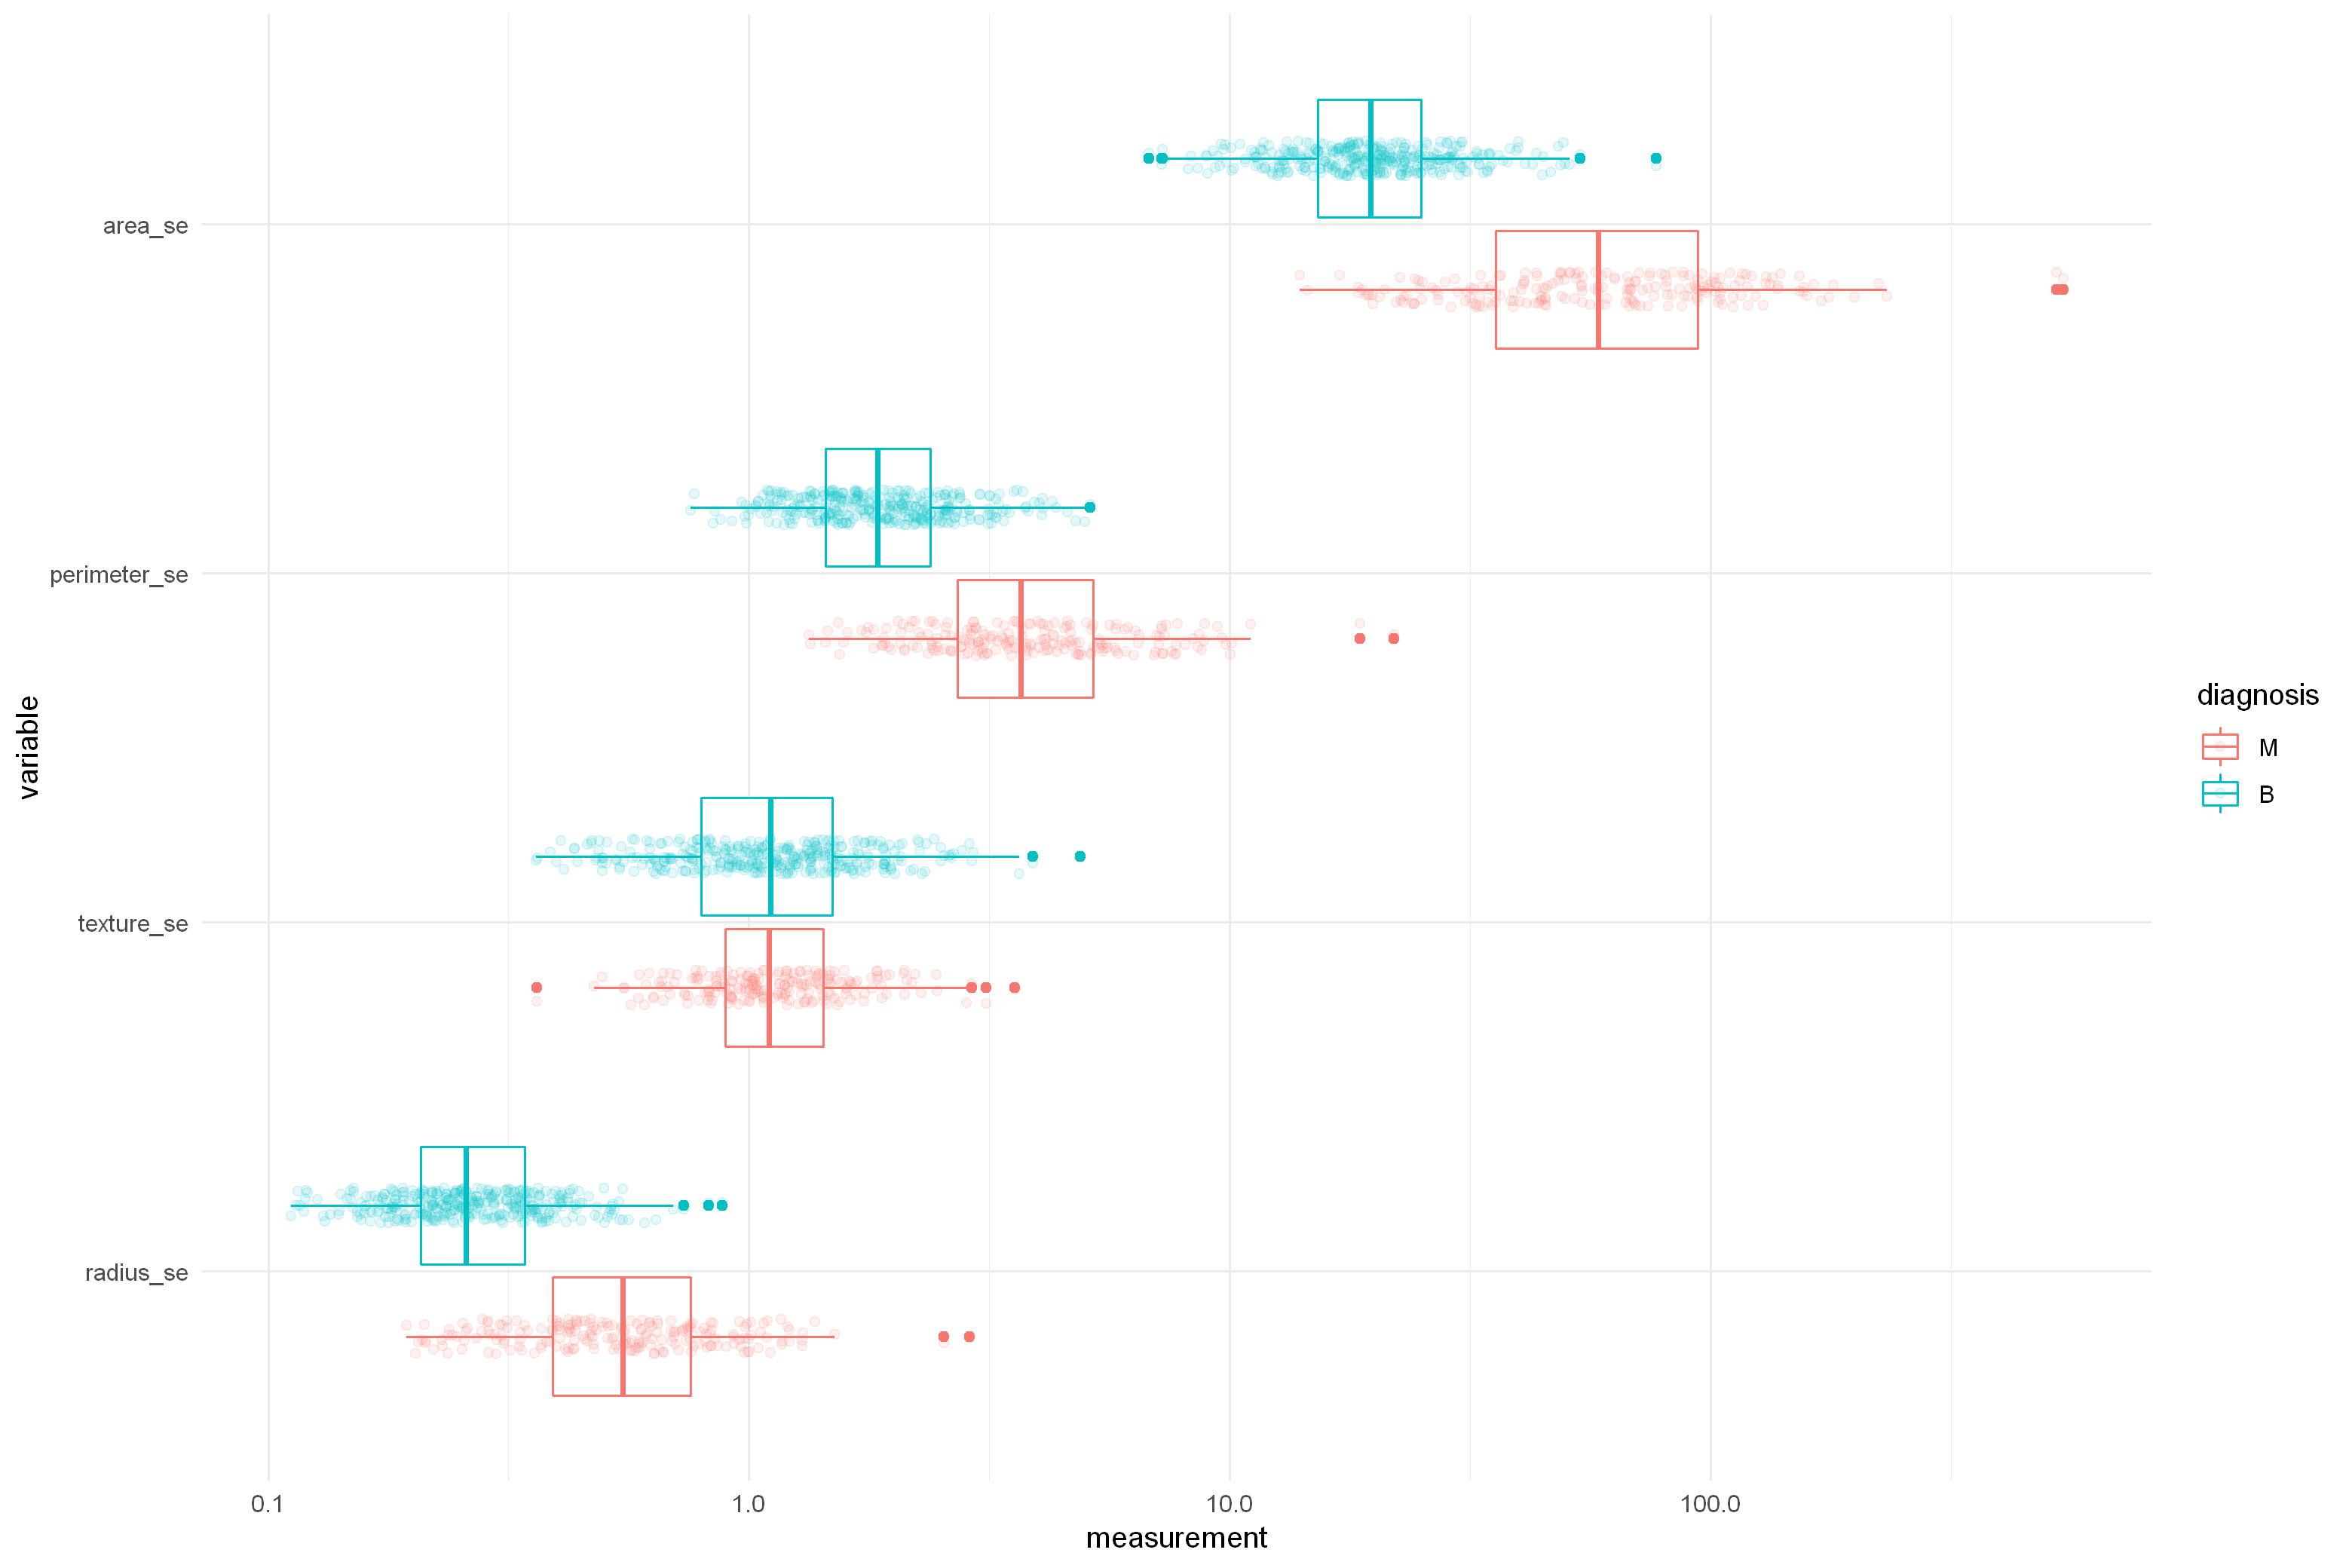

In [9]:
high_median <- c("area_se", "perimeter_se", "texture_se", "radius_se")

data_se %>%
    filter(variable %in% high_median) %>%
    ggplot(aes(x = variable, y = measurement, color = diagnosis)) + 
        geom_boxplot() + 
        geom_point(position = position_jitterdodge(jitter.width = 0.2), alpha = 0.1) + 
        theme_minimal() +
        scale_y_log10() + 
        coord_flip()

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 26 rows containing non-finite values (stat_boxplot)."


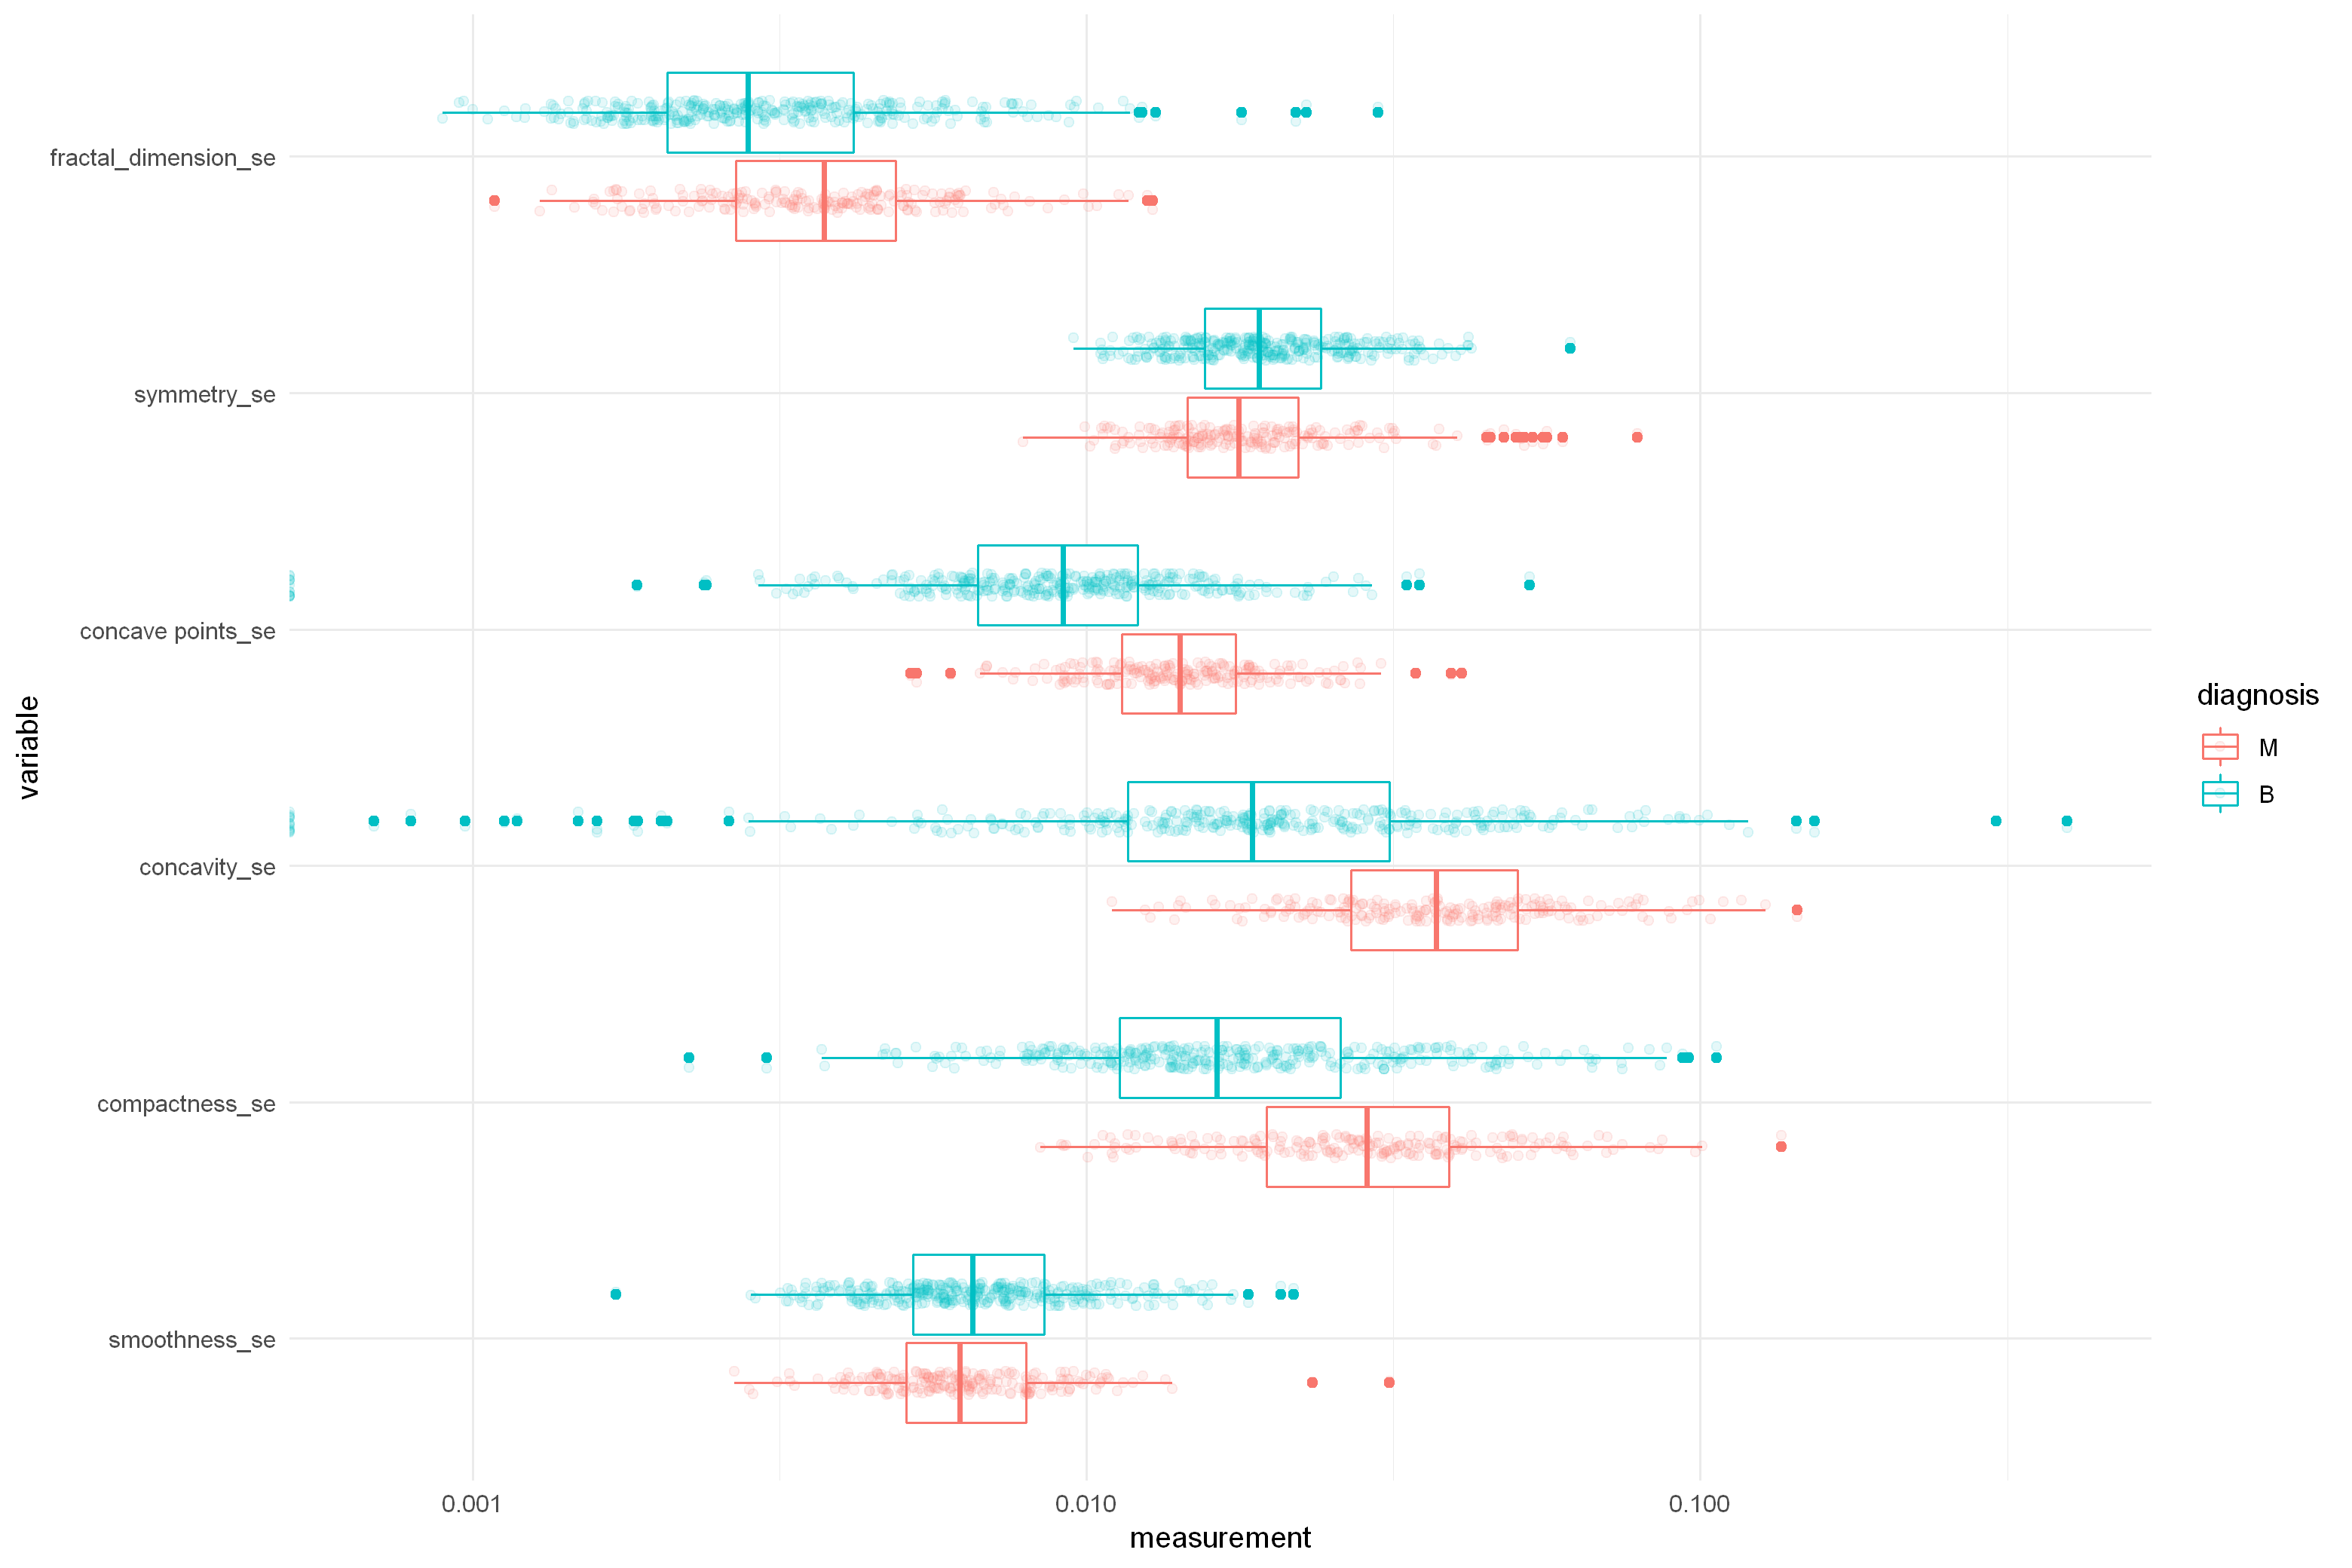

In [10]:
data_se %>%
    filter(!variable %in% high_median) %>%
    ggplot(aes(x = variable, y = measurement, color = diagnosis)) + 
        geom_boxplot() + 
        geom_point(position = position_jitterdodge(jitter.width = 0.2), alpha = 0.1) + 
        theme_minimal() +
        scale_y_log10() +
        coord_flip()

## Worst Data

In [11]:
data_worst <- data_long %>% 
    filter(grepl('_worst', variable)) %>%
    mutate(diagnosis = factor(diagnosis, levels = c("M", "B")))

data_worst %>%
    group_by(variable) %>%
    summarize(median = median(measurement)) %>%
    arrange(desc(median))

variable,median
<fct>,<dbl>
area_worst,686.50000
perimeter_worst,97.66000
texture_worst,25.41000
radius_worst,14.97000
symmetry_worst,0.28220
concavity_worst,0.22670
compactness_worst,0.21190
smoothness_worst,0.13130
concave points_worst,0.09993


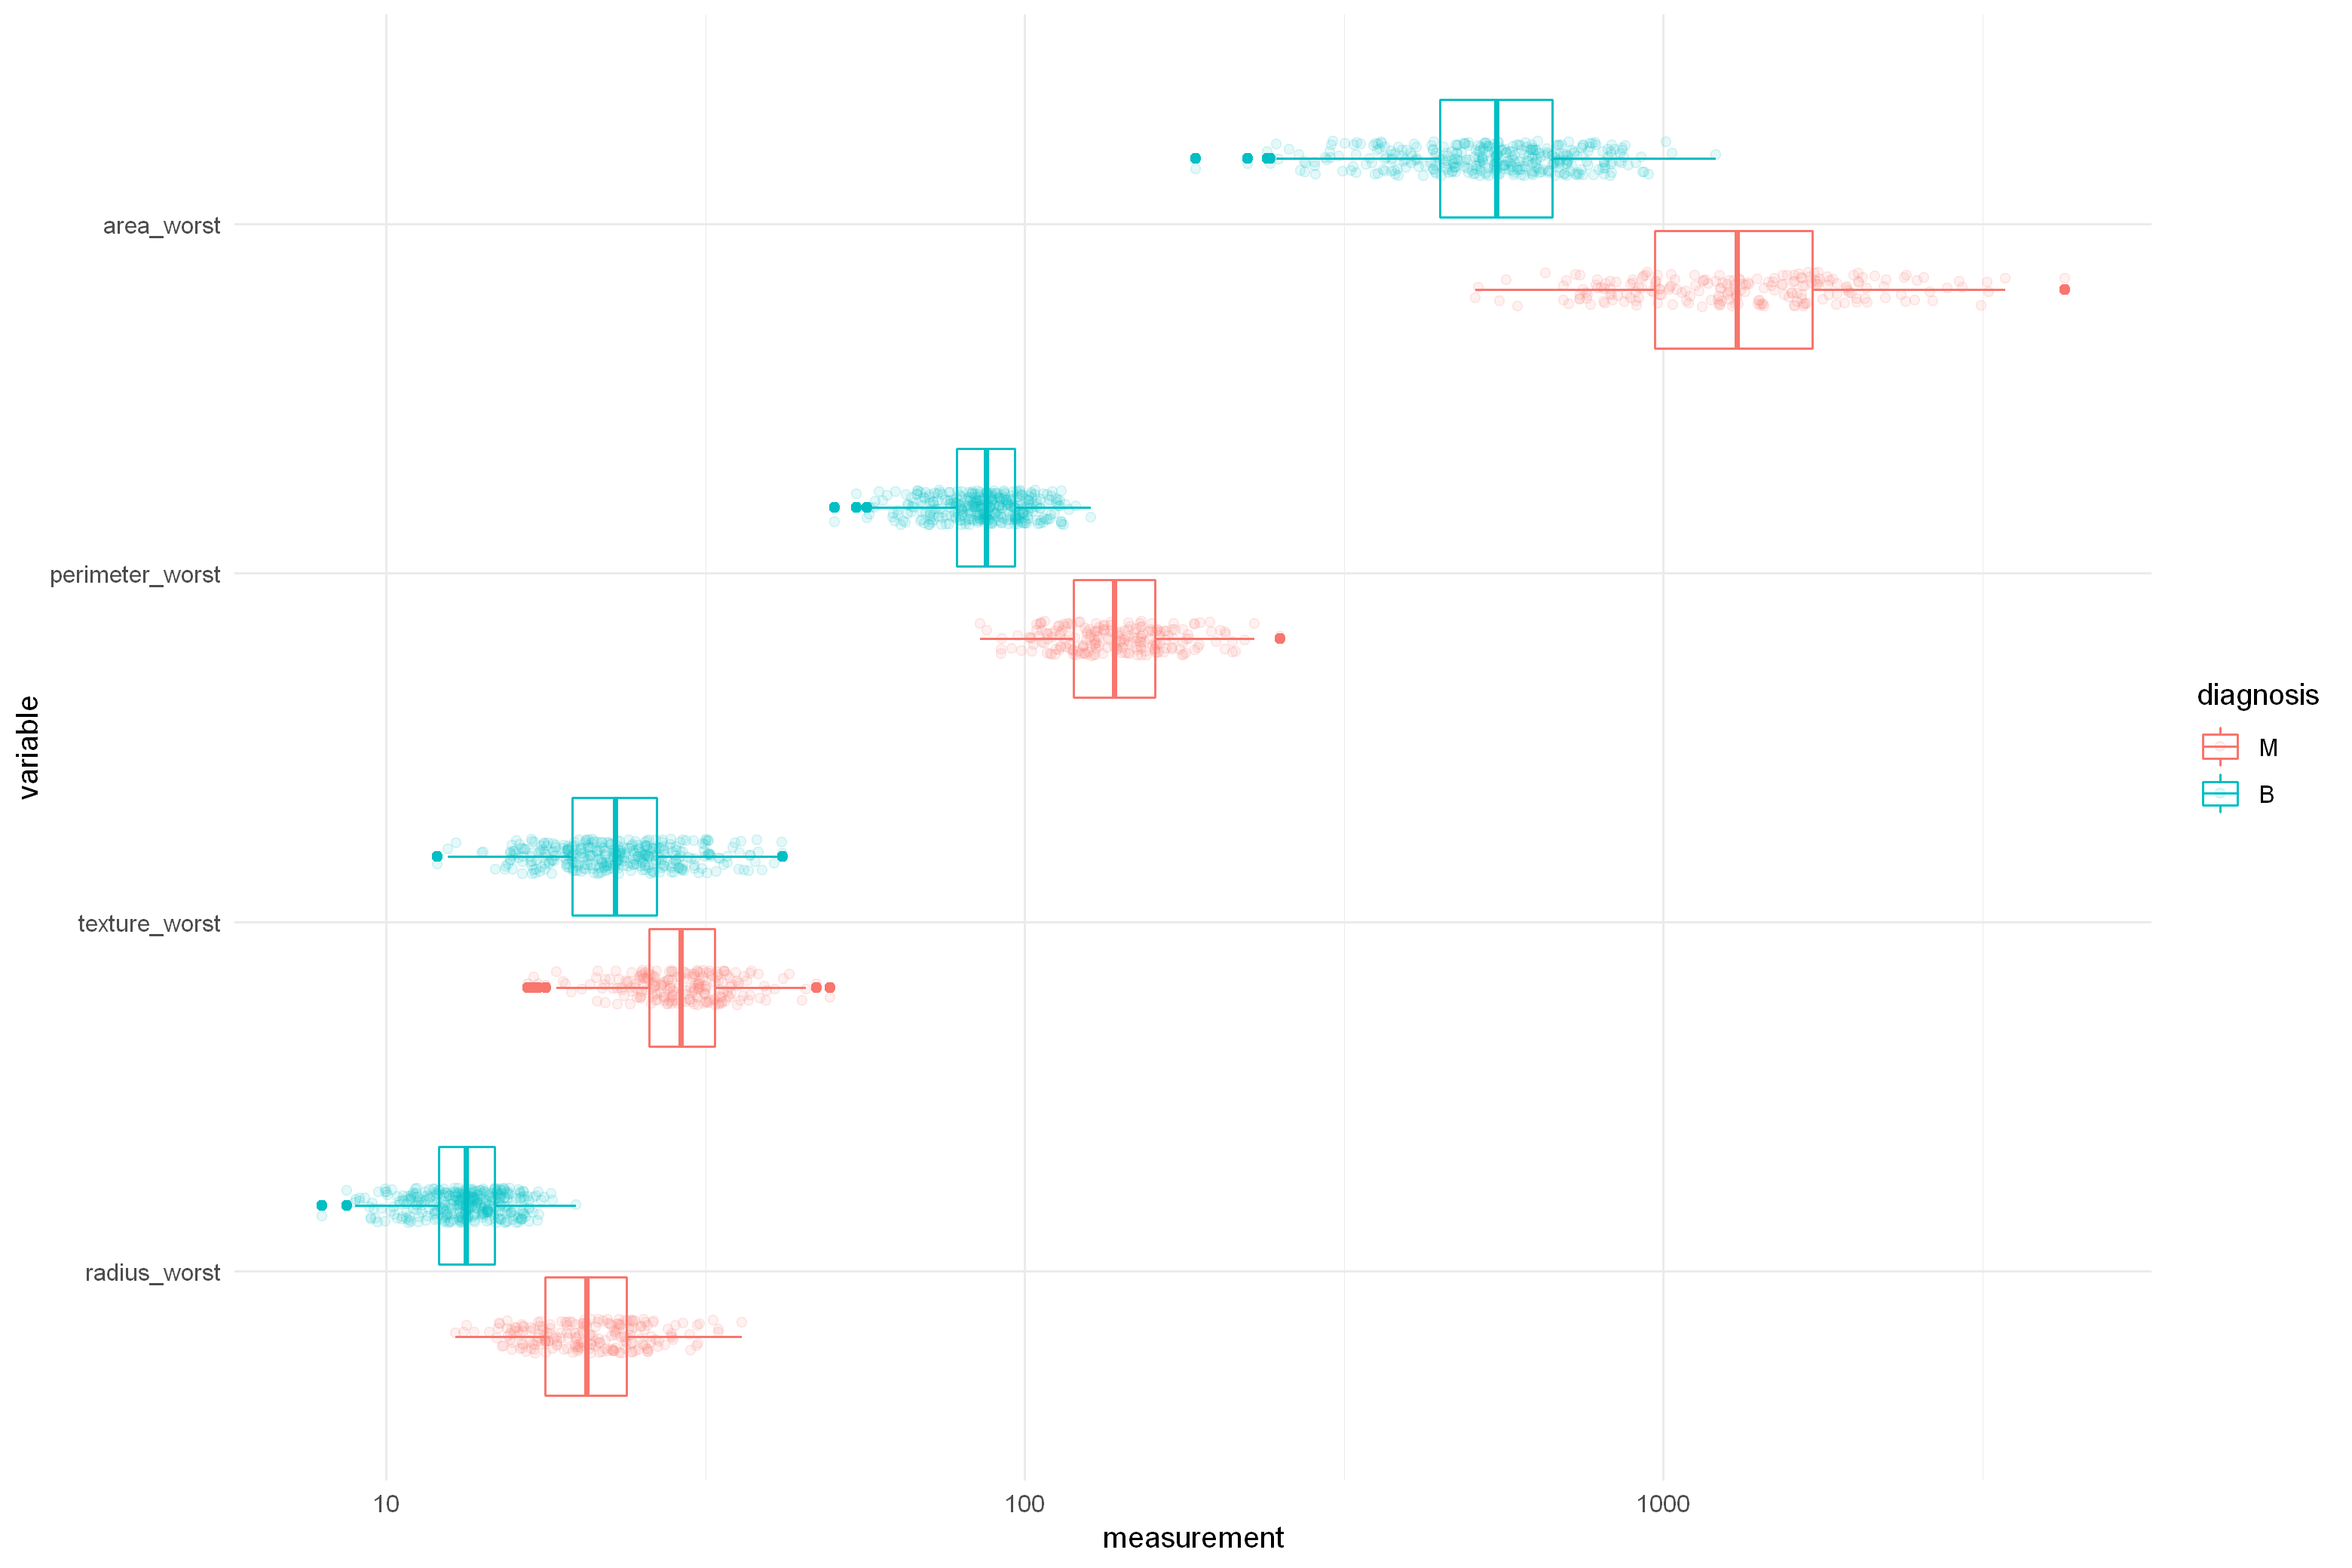

In [12]:
high_median <- c("area_worst", "perimeter_worst", "texture_worst", "radius_worst")

data_worst %>%
    filter(variable %in% high_median) %>%
    ggplot(aes(x = variable, y = measurement, color = diagnosis)) + 
        geom_boxplot() + 
        geom_point(position = position_jitterdodge(jitter.width = 0.2), alpha = 0.1) + 
        theme_minimal() +
        scale_y_log10() + 
        coord_flip()

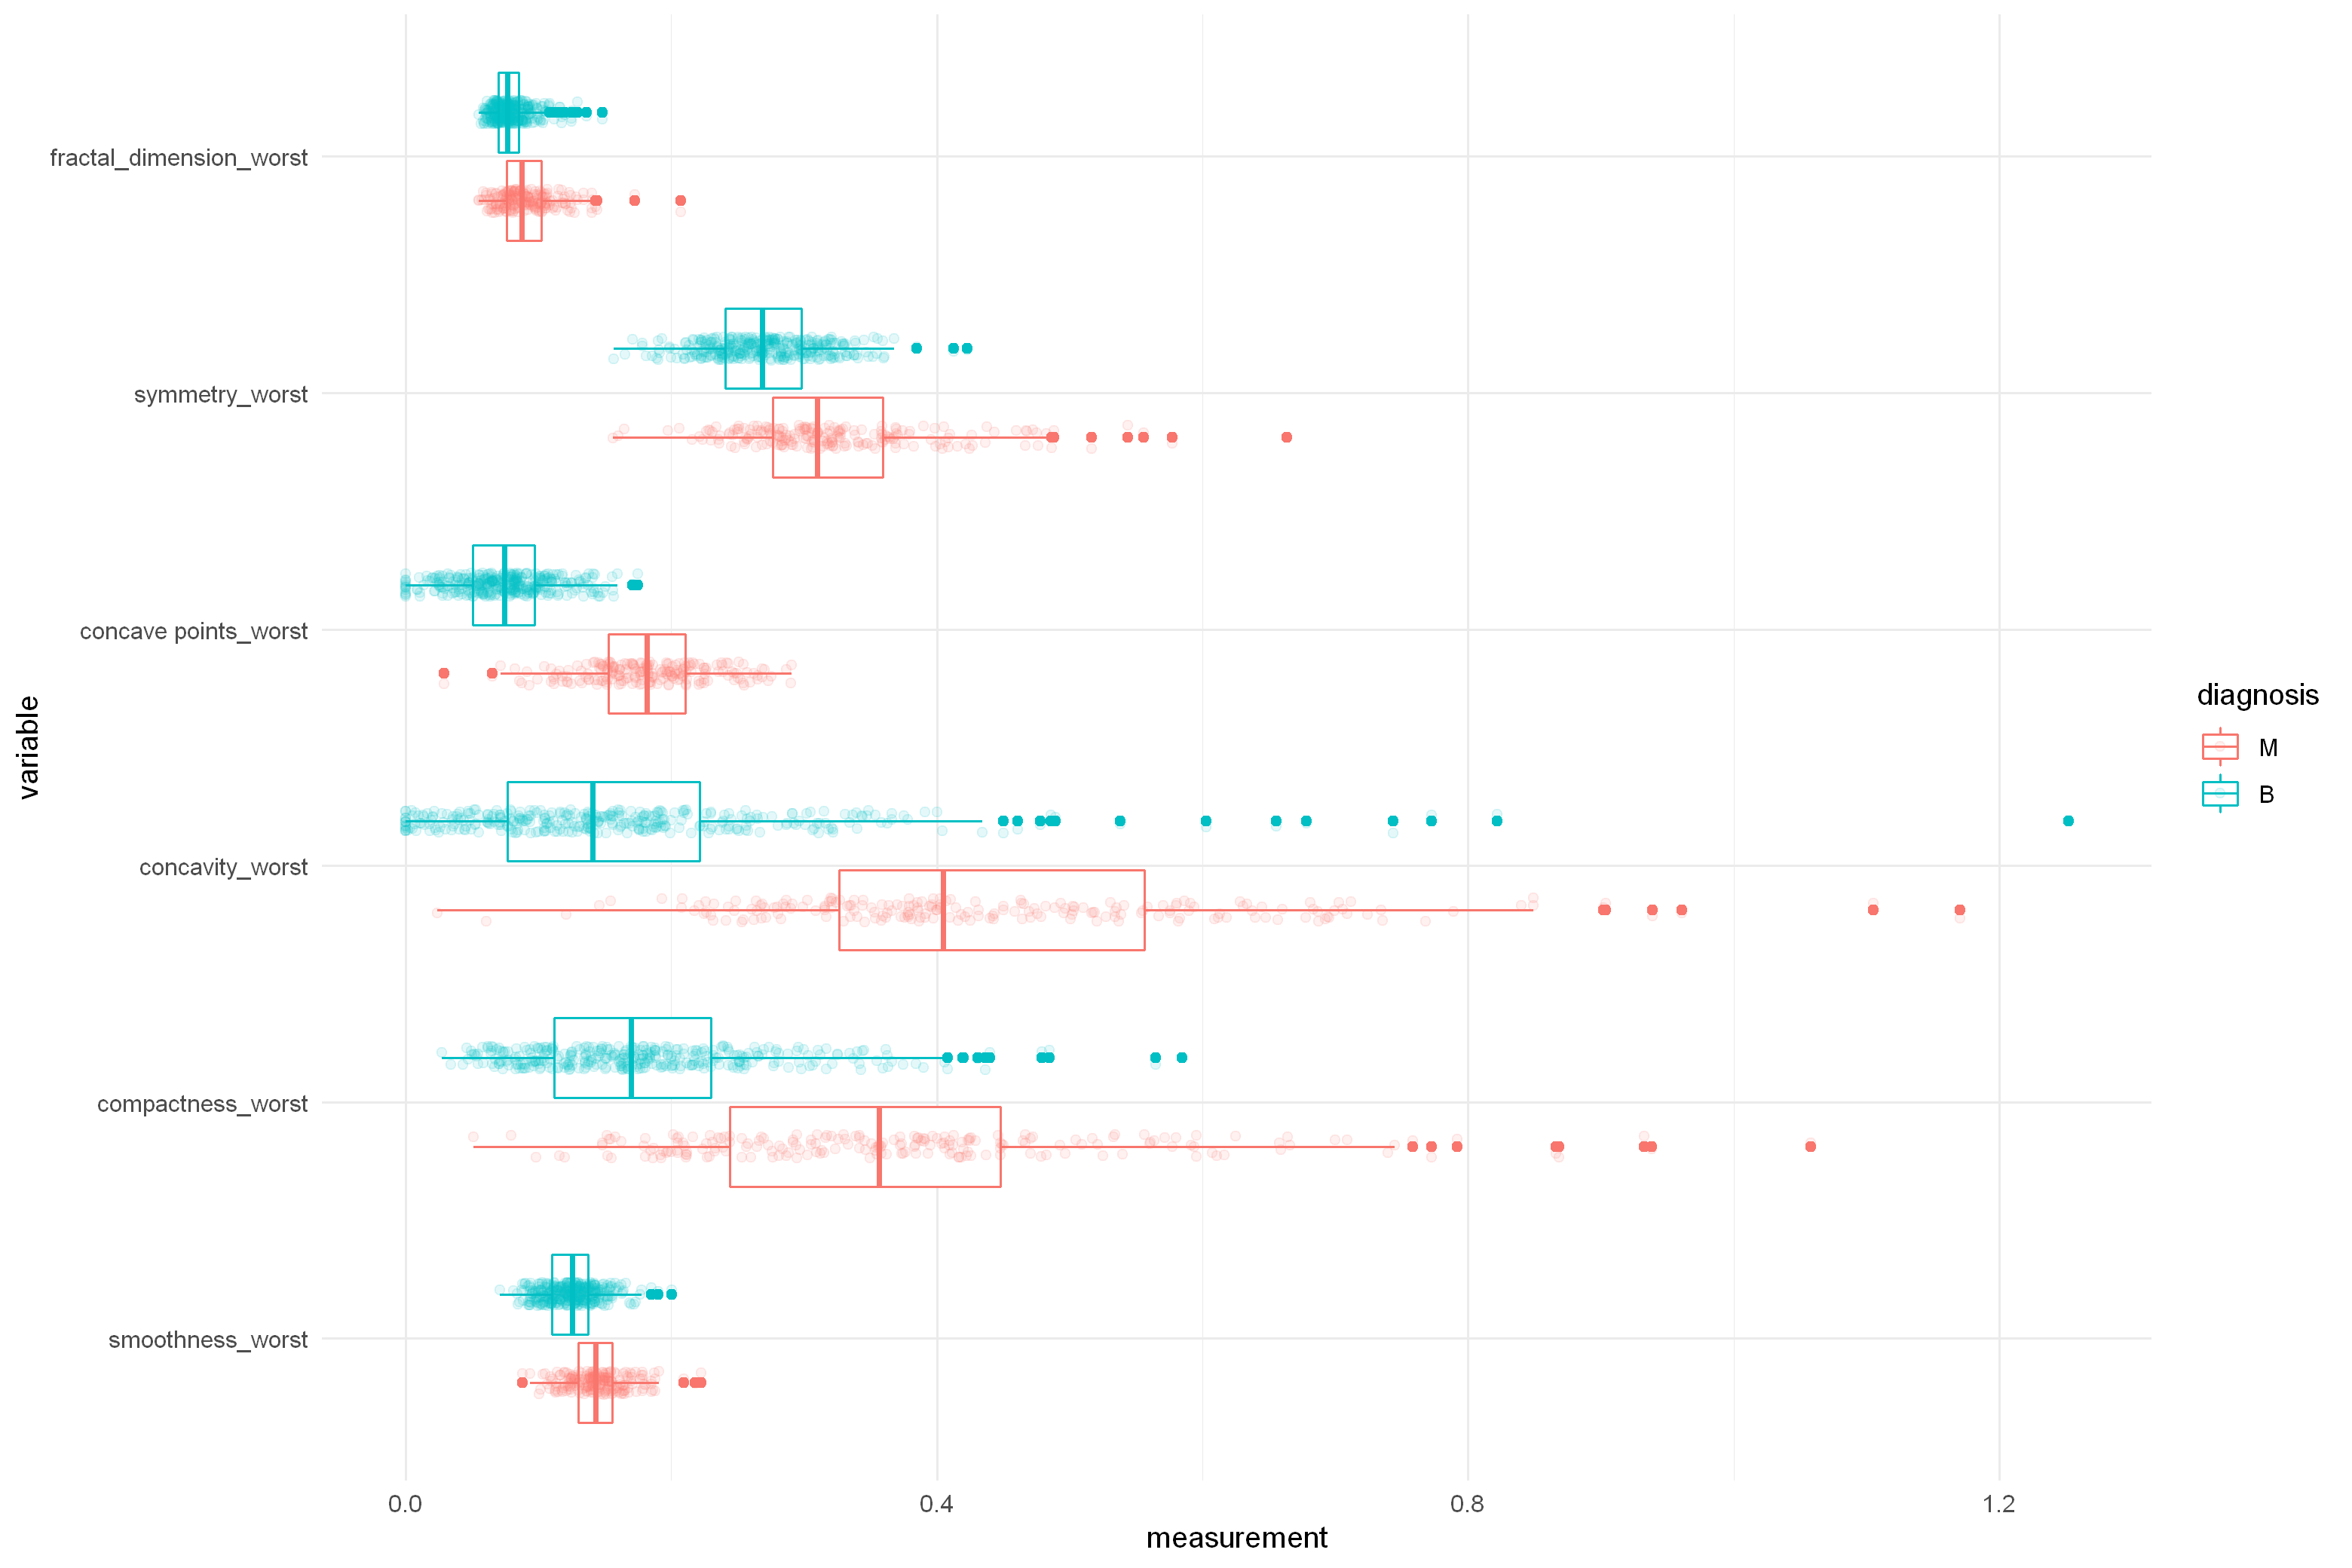

In [13]:
data_worst %>%
    filter(!variable %in% high_median) %>%
    ggplot(aes(x = variable, y = measurement, color = diagnosis)) + 
        geom_boxplot() + 
        geom_point(position = position_jitterdodge(jitter.width = 0.2), alpha = 0.1) + 
        theme_minimal() +
        coord_flip()

# Pre-Process

## Finding Variables with High Correlations to Diagnosis

In [14]:
corr_data <- data %>%
    mutate(diagnosis = ifelse(diagnosis == "M", 1, 0))

mean_corr <- corr_data %>%
    select(diagnosis, radius_mean:fractal_dimension_mean) %>%
    cor()

print(mean_corr[1,])

             diagnosis            radius_mean           texture_mean 
             1.0000000              0.7300285              0.4151853 
        perimeter_mean              area_mean        smoothness_mean 
             0.7426355              0.7089838              0.3585600 
      compactness_mean         concavity_mean    concave points_mean 
             0.5965337              0.6963597              0.7766138 
         symmetry_mean fractal_dimension_mean 
             0.3304986             -0.0128376 


In [15]:
se_corr <- corr_data %>%
    select(diagnosis, radius_se:fractal_dimension_se) %>%
    cor()

print(se_corr[1,])

           diagnosis            radius_se           texture_se 
         1.000000000          0.567133821         -0.008303333 
        perimeter_se              area_se        smoothness_se 
         0.556140703          0.548235940         -0.067016011 
      compactness_se         concavity_se    concave points_se 
         0.292999244          0.253729766          0.408042333 
         symmetry_se fractal_dimension_se 
        -0.006521756          0.077972417 


In [16]:
worst_corr <- corr_data %>%
    select(diagnosis, radius_worst:fractal_dimension_worst) %>%
    cor()

print(worst_corr[1,])

              diagnosis            radius_worst           texture_worst 
              1.0000000               0.7764538               0.4569028 
        perimeter_worst              area_worst        smoothness_worst 
              0.7829141               0.7338250               0.4214649 
      compactness_worst         concavity_worst    concave points_worst 
              0.5909982               0.6596102               0.7935660 
         symmetry_worst fractal_dimension_worst 
              0.4162943               0.3238722 


In [17]:
# selecting vars with high correlation
set.seed(22012000)

data_model <- data %>%
    select(diagnosis, radius_mean, perimeter_mean, area_mean, "concave points_mean", radius_worst, perimeter_worst,
           area_worst, "concave points_worst") %>%
    mutate(diagnosis = factor(diagnosis, levels = c("M", "B")))

In [18]:
data_split <- initial_split(data_model)

In [19]:
data_split %>% training() %>% glimpse()

Rows: 426
Columns: 9
$ diagnosis              <fct> M, M, B, B, M, M, B, M, B, M, B, B, M, B, B, B,~
$ radius_mean            <dbl> 16.600, 14.270, 11.130, 11.750, 21.370, 19.550,~
$ perimeter_mean         <dbl> 108.30, 93.77, 71.49, 76.10, 141.30, 133.60, 81~
$ area_mean              <dbl> 858.1, 629.8, 378.4, 419.8, 1386.0, 1207.0, 481~
$ `concave points_mean`  <dbl> 0.053020, 0.061390, 0.022570, 0.037380, 0.12550~
$ radius_worst           <dbl> 18.98, 15.29, 12.02, 13.32, 22.69, 25.05, 14.97~
$ perimeter_worst        <dbl> 126.70, 104.30, 77.80, 88.91, 152.10, 178.60, 9~
$ area_worst             <dbl> 1124.0, 728.3, 436.6, 543.9, 1535.0, 1926.0, 67~
$ `concave points_worst` <dbl> 0.14180, 0.13620, 0.06413, 0.07909, 0.19660, 0.~


In [20]:
model_recipe <- training(data_split) %>%
    recipe(diagnosis ~.) %>%
    step_corr(all_predictors()) %>%
    step_center(all_predictors(), -all_outcomes()) %>%
    step_scale(all_predictors(), -all_outcomes()) %>%
    prep()

model_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          8

Training data contained 426 data points and no missing data.

Operations:

Correlation filter removed perimeter_mean, ... [trained]
Centering for area_worst, concave points_worst [trained]
Scaling for area_worst, concave points_worst [trained]

In [21]:
model_testing <- model_recipe %>%
    bake(testing(data_split)) 

glimpse(model_testing)

Rows: 143
Columns: 3
$ area_worst             <dbl> 1.27598836, -0.21378218, 0.06400801, 0.78261583~
$ `concave points_worst` <dbl> 0.7548289, 0.9303632, 0.6504162, 1.0347759, 0.9~
$ diagnosis              <fct> M, M, M, M, M, M, M, B, M, M, M, M, M, M, M, B,~


In [22]:
model_training <- juice(model_recipe)

glimpse(model_training)

Rows: 426
Columns: 3
$ area_worst             <dbl> 0.46978904, -0.23755701, -0.75899457, -0.567187~
$ `concave points_worst` <dbl> 0.44159092, 0.35685021, -0.73373245, -0.5073537~
$ diagnosis              <fct> M, M, B, B, M, M, B, M, B, M, B, B, M, B, B, B,~


# Random Forest Model

## Model Training

In [23]:
model_rf <-  rand_forest(trees = 100, mode = "classification") %>%
    set_engine("randomForest") %>%
    fit(diagnosis ~ ., data = model_training)

In [24]:
model_rf %>%
    predict(model_testing) %>%
    bind_cols(model_testing) %>%
    glimpse()

Rows: 143
Columns: 4
$ .pred_class            <fct> M, M, M, M, M, M, M, B, M, M, M, M, M, M, M, B,~
$ area_worst             <dbl> 1.27598836, -0.21378218, 0.06400801, 0.78261583~
$ `concave points_worst` <dbl> 0.7548289, 0.9303632, 0.6504162, 1.0347759, 0.9~
$ diagnosis              <fct> M, M, M, M, M, M, M, B, M, M, M, M, M, M, M, B,~


## Model Validation 

In [25]:
model_rf %>%
    predict(model_testing) %>%
    bind_cols(model_testing) %>%
    metrics(truth = diagnosis, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9650350
kap,binary,0.9287636


In [26]:
model_probs <- model_rf %>%
    predict(model_testing, type = "prob") %>%
    bind_cols(model_testing)

glimpse(model_probs)

Rows: 143
Columns: 5
$ .pred_M                <dbl> 1.00, 0.90, 0.93, 1.00, 1.00, 0.96, 1.00, 0.00,~
$ .pred_B                <dbl> 0.00, 0.10, 0.07, 0.00, 0.00, 0.04, 0.00, 1.00,~
$ area_worst             <dbl> 1.27598836, -0.21378218, 0.06400801, 0.78261583~
$ `concave points_worst` <dbl> 0.7548289, 0.9303632, 0.6504162, 1.0347759, 0.9~
$ diagnosis              <fct> M, M, M, M, M, M, M, B, M, M, M, M, M, M, M, B,~


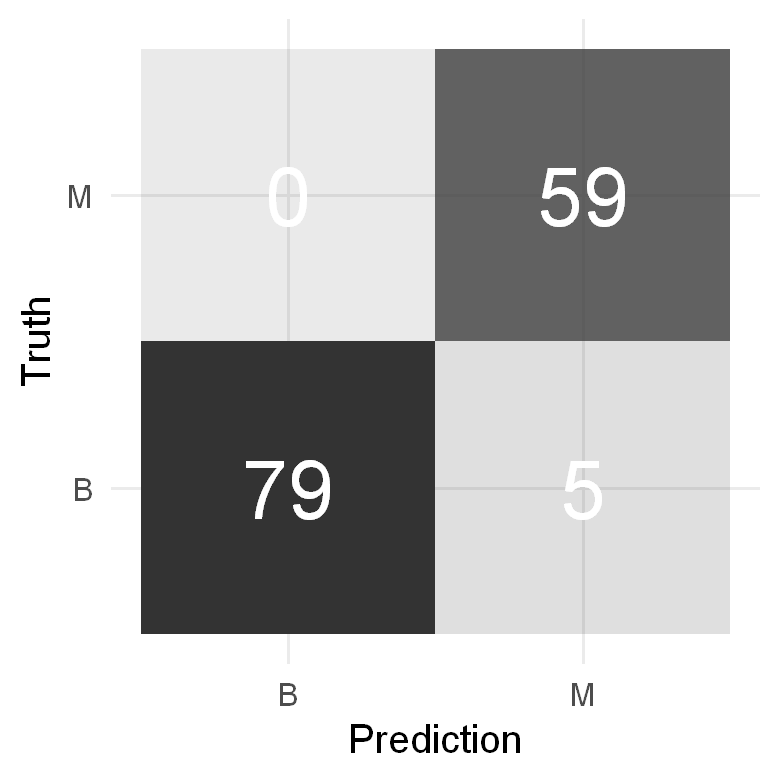

In [27]:
conf <- model_rf %>% 
    predict(model_testing) %>%
    bind_cols(model_testing %>% select(diagnosis)) %>%
    conf_mat(diagnosis, .pred_class)

options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=260)
conf %>%
    pluck(1) %>%
    as_tibble() %>%
    ggplot(aes(Prediction, Truth, alpha = n)) +
    geom_tile(show.legend = FALSE) +
    geom_text(aes(label = n), colour = "white", alpha = 1, size = 8) + 
    theme_minimal()

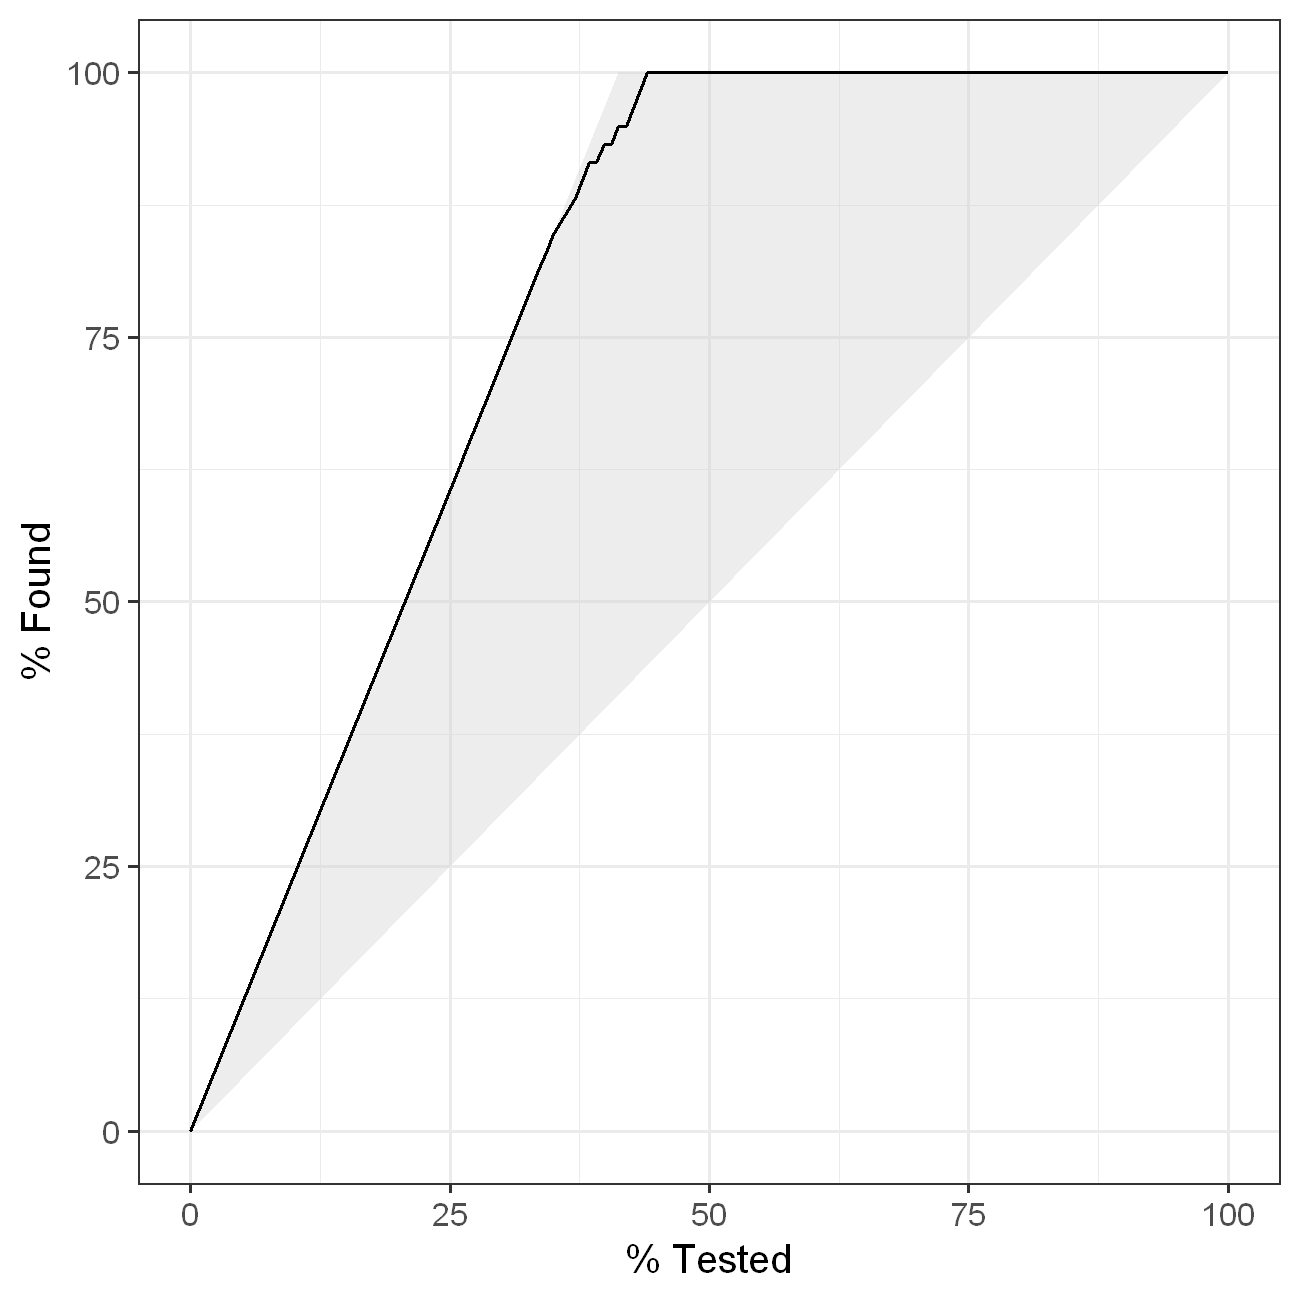

In [28]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res=260)
model_probs %>%
    gain_curve(diagnosis, .pred_M) %>%
    autoplot()

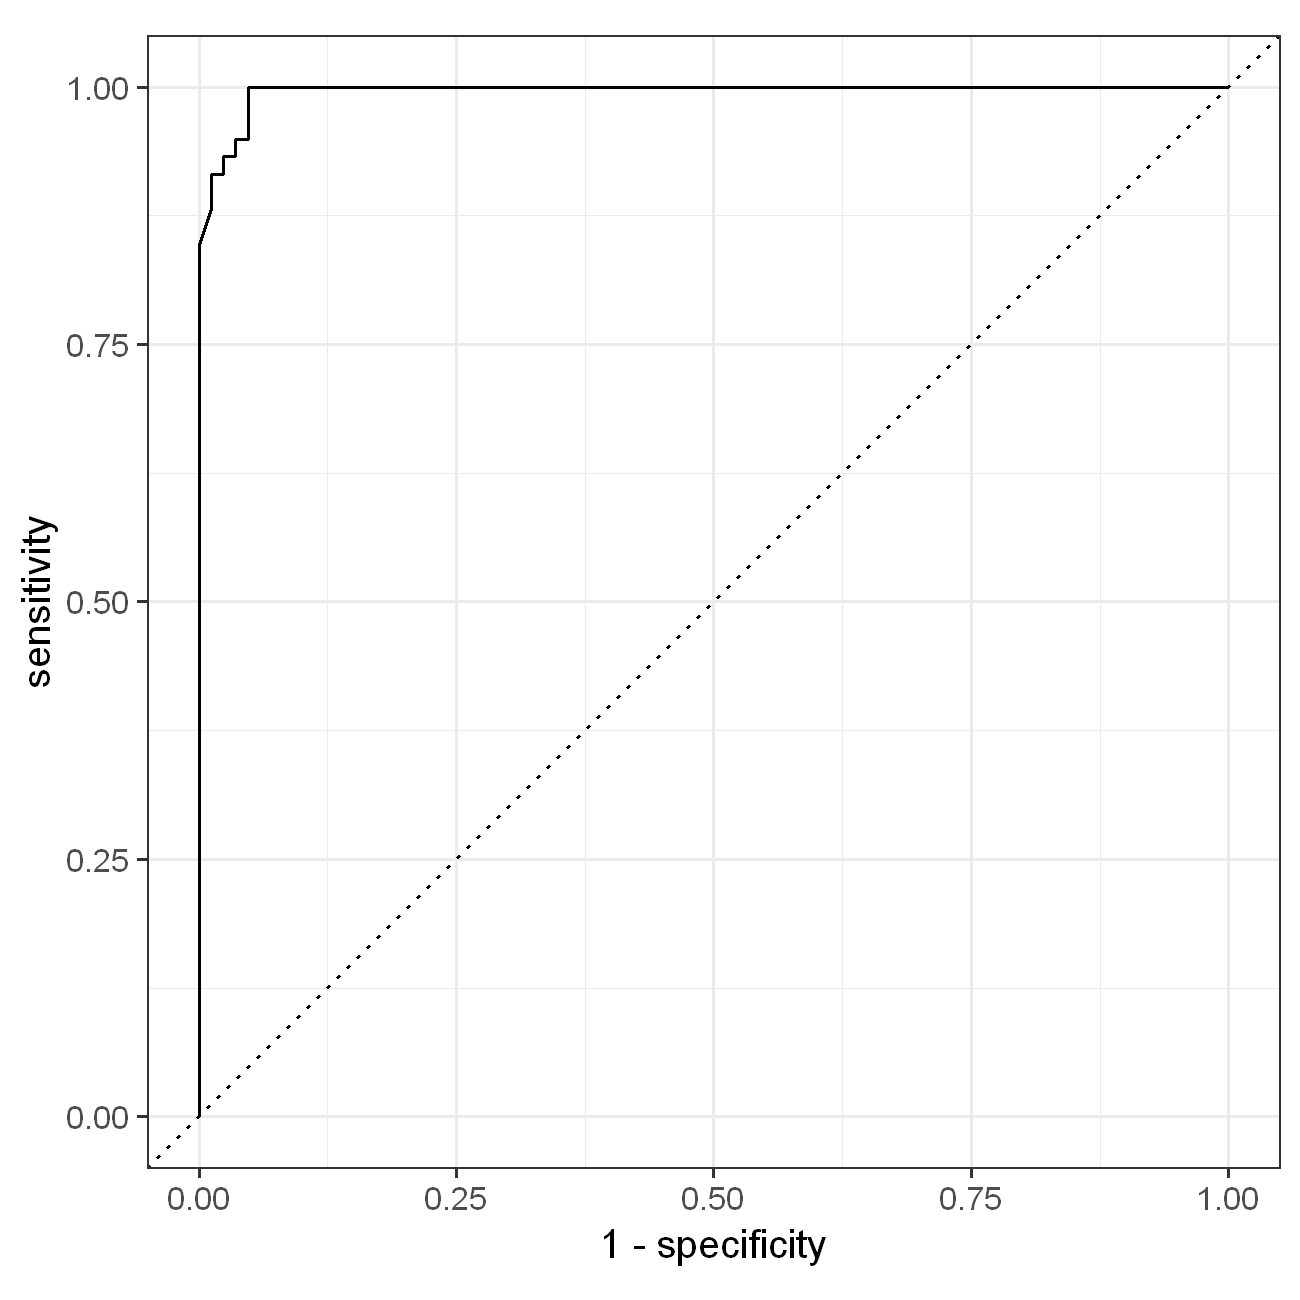

In [29]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res=260)
model_probs %>%
    roc_curve(diagnosis, .pred_M) %>%
    autoplot()

In [30]:
predict(model_rf, model_testing, type = "prob") %>%
    bind_cols(predict(model_rf, model_testing)) %>%
    bind_cols(select(model_testing, diagnosis)) %>%
    metrics(diagnosis, .pred_M, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.96503497
kap,binary,0.92876357
mn_log_loss,binary,0.09615268
roc_auc,binary,0.99596449


# K-Nearest Neighbors Model

## Model Training

In [31]:
model_knn <- nearest_neighbor(mode = "classification", 
                              neighbors = 5, 
                              weight_func = "gaussian", 
                              dist_power = 2) %>%
    set_engine("kknn") %>%
    fit(diagnosis ~ ., data = model_training)

In [32]:
model_knn %>%
    predict(model_testing) %>%
    bind_cols(model_testing) %>%
    glimpse()

Rows: 143
Columns: 4
$ .pred_class            <fct> M, M, M, M, M, M, M, B, M, M, M, M, M, M, M, B,~
$ area_worst             <dbl> 1.27598836, -0.21378218, 0.06400801, 0.78261583~
$ `concave points_worst` <dbl> 0.7548289, 0.9303632, 0.6504162, 1.0347759, 0.9~
$ diagnosis              <fct> M, M, M, M, M, M, M, B, M, M, M, M, M, M, M, B,~


## Model Validation

In [33]:
model_knn %>%
    predict(model_testing) %>%
    bind_cols(model_testing) %>%
    metrics(truth = diagnosis, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9650350
kap,binary,0.9287636


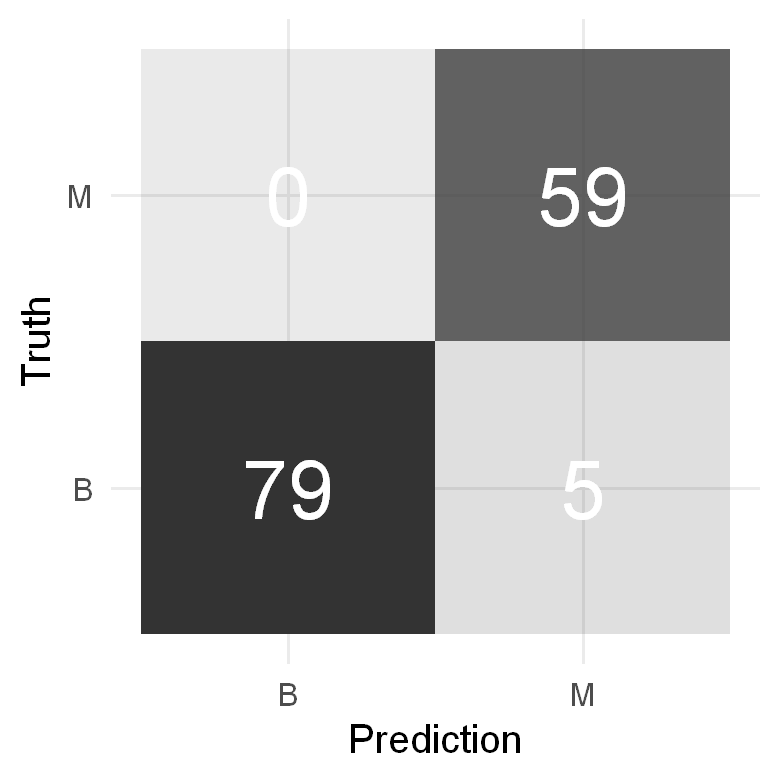

In [34]:
conf_knn <- model_knn %>% 
    predict(model_testing) %>%
    bind_cols(model_testing %>% select(diagnosis)) %>%
    conf_mat(diagnosis, .pred_class)

options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=260)
conf_knn %>%
    pluck(1) %>%
    as_tibble() %>%
    ggplot(aes(Prediction, Truth, alpha = n)) +
    geom_tile(show.legend = FALSE) +
    geom_text(aes(label = n), colour = "white", alpha = 1, size = 8) + 
    theme_minimal()

# Alternative Workflow

In [35]:
data_train <- training(data_split)
data_test <- testing(data_split)

data_bootstrap <- bootstraps(data_train)

In [36]:
# specifying models, comparison of above two plus logistic regression
model_alt_glm <- logistic_reg() %>%
    set_engine("glm")

model_alt_rf <- rand_forest(trees = 100, mode = "classification") %>%
    set_engine("randomForest")

model_alt_knn <- nearest_neighbor(mode = "classification", 
                                  neighbors = 5, 
                                  weight_func = "gaussian", 
                                  dist_power = 2) %>%
    set_engine("kknn")

In [37]:
diagnosis_workflow <- workflow() %>%
    add_formula(diagnosis ~ .)

In [38]:
glm_results <- diagnosis_workflow %>%
    add_model(model_alt_glm) %>%
    fit_resamples(resamples = data_bootstrap, control = control_resamples(save_pred = TRUE))

rf_results <- diagnosis_workflow %>%
    add_model(model_alt_rf) %>%
    fit_resamples(resamples = data_bootstrap, control = control_resamples(save_pred = TRUE))

knn_results <- diagnosis_workflow %>%
    add_model(model_alt_knn) %>%
    fit_resamples(resamples = data_bootstrap, control = control_resamples(save_pred = TRUE))

! Bootstrap01: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap02: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap03: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap04: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap05: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap06: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap07: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap08: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap09: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap10: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap11: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numeri

In [39]:
collect_metrics(glm_results)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.9465726,25,0.002902402,Preprocessor1_Model1
roc_auc,binary,0.9843733,25,0.001904818,Preprocessor1_Model1


In [40]:
collect_metrics(rf_results)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.9434532,25,0.002986577,Preprocessor1_Model1
roc_auc,binary,0.9785875,25,0.002067028,Preprocessor1_Model1


In [41]:
collect_metrics(knn_results)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.9514372,25,0.002188987,Preprocessor1_Model1
roc_auc,binary,0.9683714,25,0.001693419,Preprocessor1_Model1


In [42]:
results <- collect_metrics(glm_results) %>%
    mutate(model = "glm") %>%
    bind_rows(collect_metrics(rf_results) %>% mutate(model = "rf")) %>%
    bind_rows(collect_metrics(knn_results) %>% mutate(model = "knn"))

results

.metric,.estimator,mean,n,std_err,.config,model
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>
accuracy,binary,0.9465726,25,0.002902402,Preprocessor1_Model1,glm
roc_auc,binary,0.9843733,25,0.001904818,Preprocessor1_Model1,glm
accuracy,binary,0.9434532,25,0.002986577,Preprocessor1_Model1,rf
roc_auc,binary,0.9785875,25,0.002067028,Preprocessor1_Model1,rf
accuracy,binary,0.9514372,25,0.002188987,Preprocessor1_Model1,knn
roc_auc,binary,0.9683714,25,0.001693419,Preprocessor1_Model1,knn


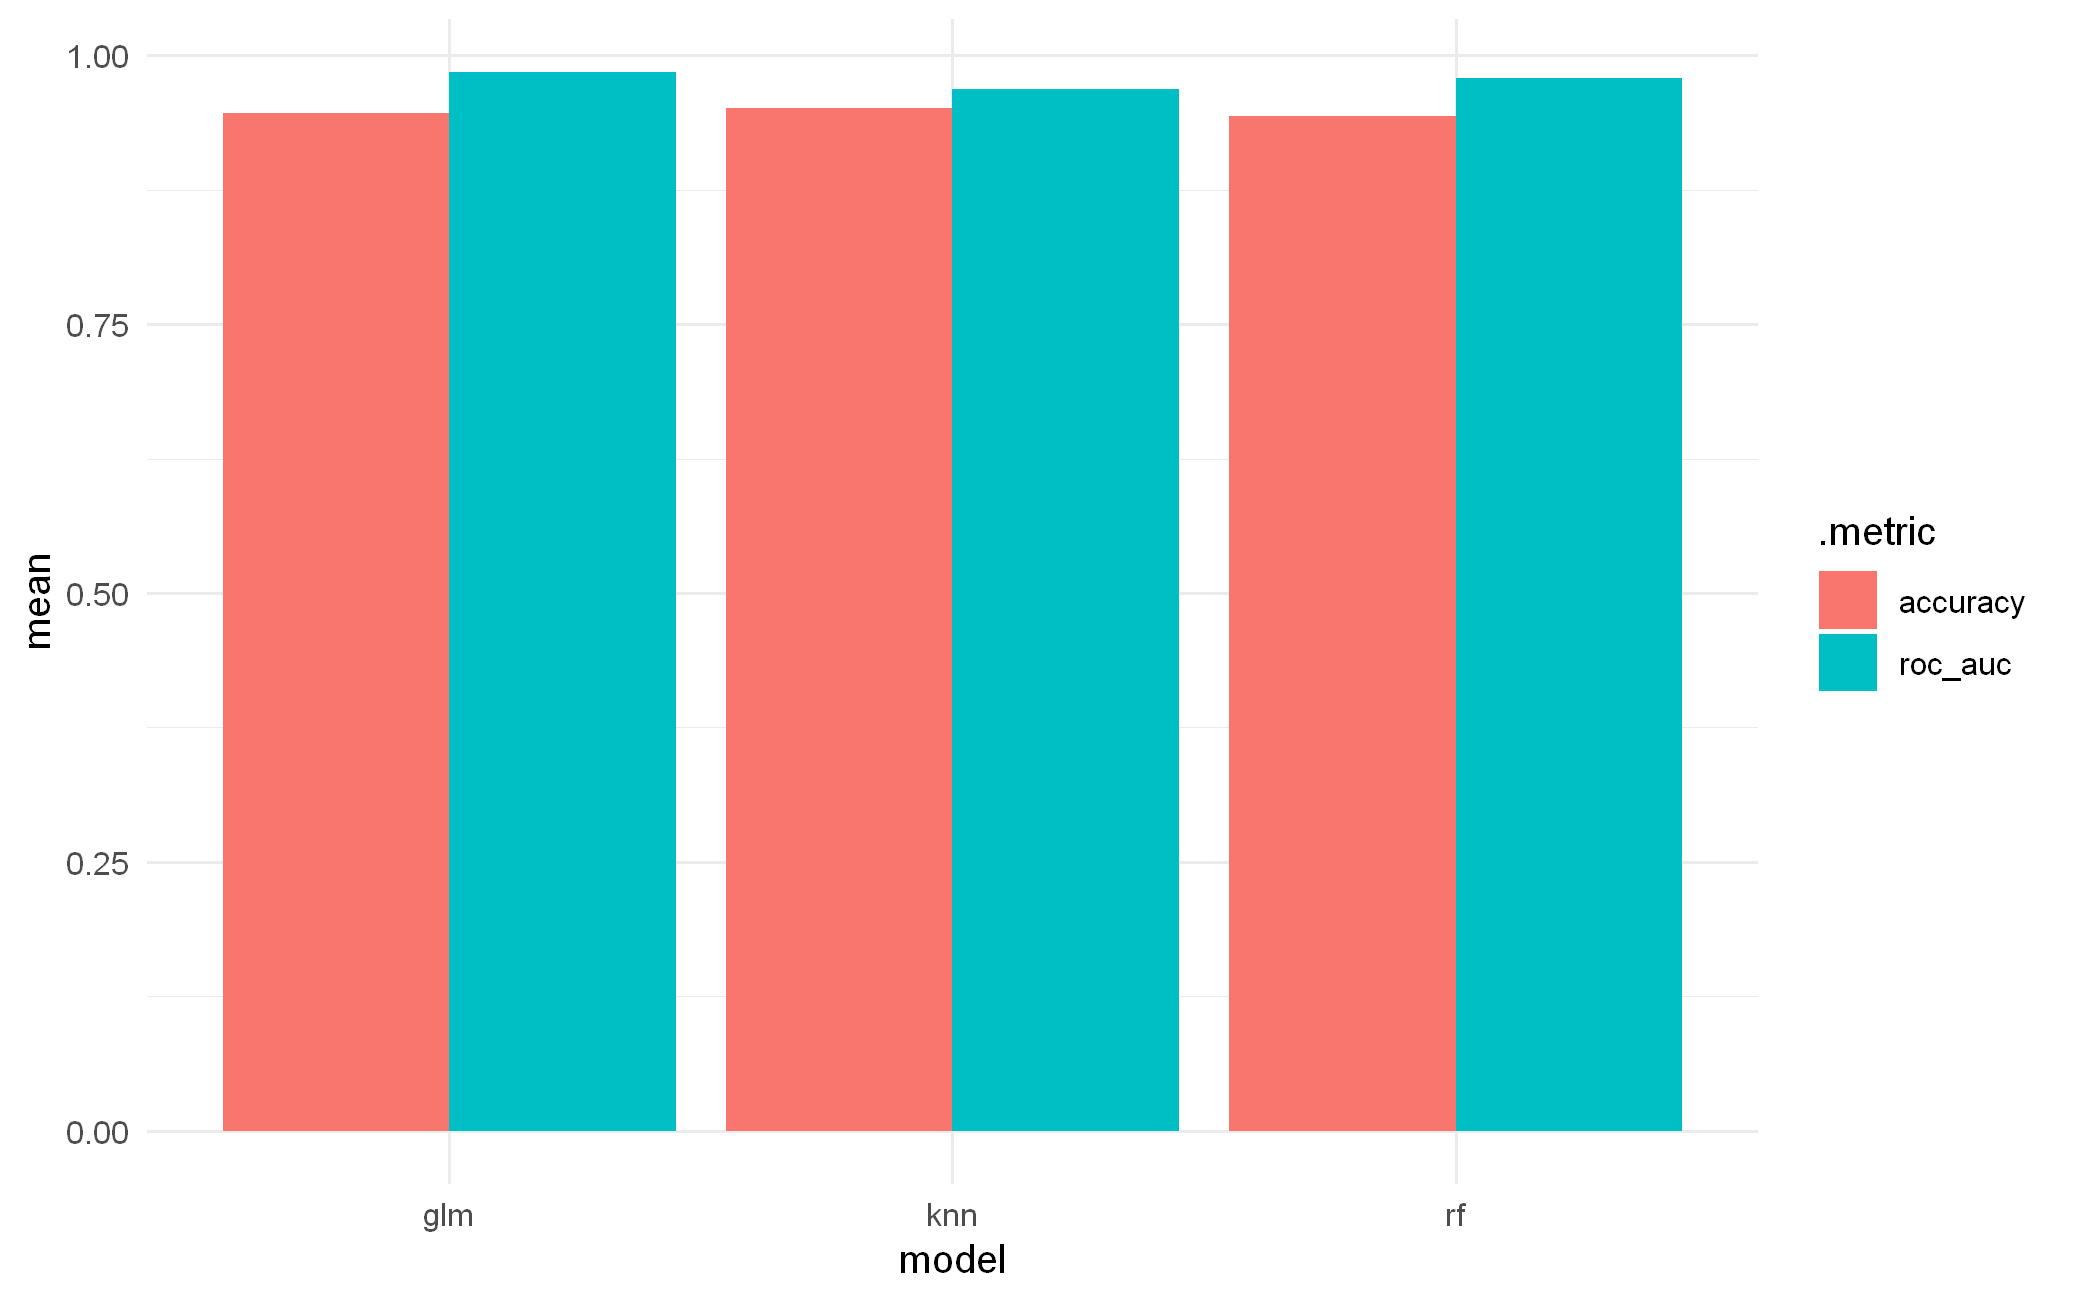

In [43]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res=260)
ggplot(results, aes(model, mean, fill = .metric)) + 
    geom_col(position = "dodge") + 
    theme_minimal()

In [44]:
glm_bootstrap_results <- glm_results %>%
    collect_predictions() %>%
    group_by(id) %>%
    summarize(accuracy = mean(.pred_class == diagnosis))

knn_bootstrap_results <- knn_results %>%
    collect_predictions() %>%
    group_by(id) %>%
    summarize(accuracy = mean(.pred_class == diagnosis))

rf_bootstrap_results <- rf_results %>%
    collect_predictions() %>%
    group_by(id) %>%
    summarize(accuracy = mean(.pred_class == diagnosis))

bootstrap_results <- glm_bootstrap_results %>%
    mutate(model = "glm") %>%
    bind_rows(knn_bootstrap_results %>% mutate(model = "knn")) %>%
    bind_rows(rf_bootstrap_results %>% mutate(model = "rf"))

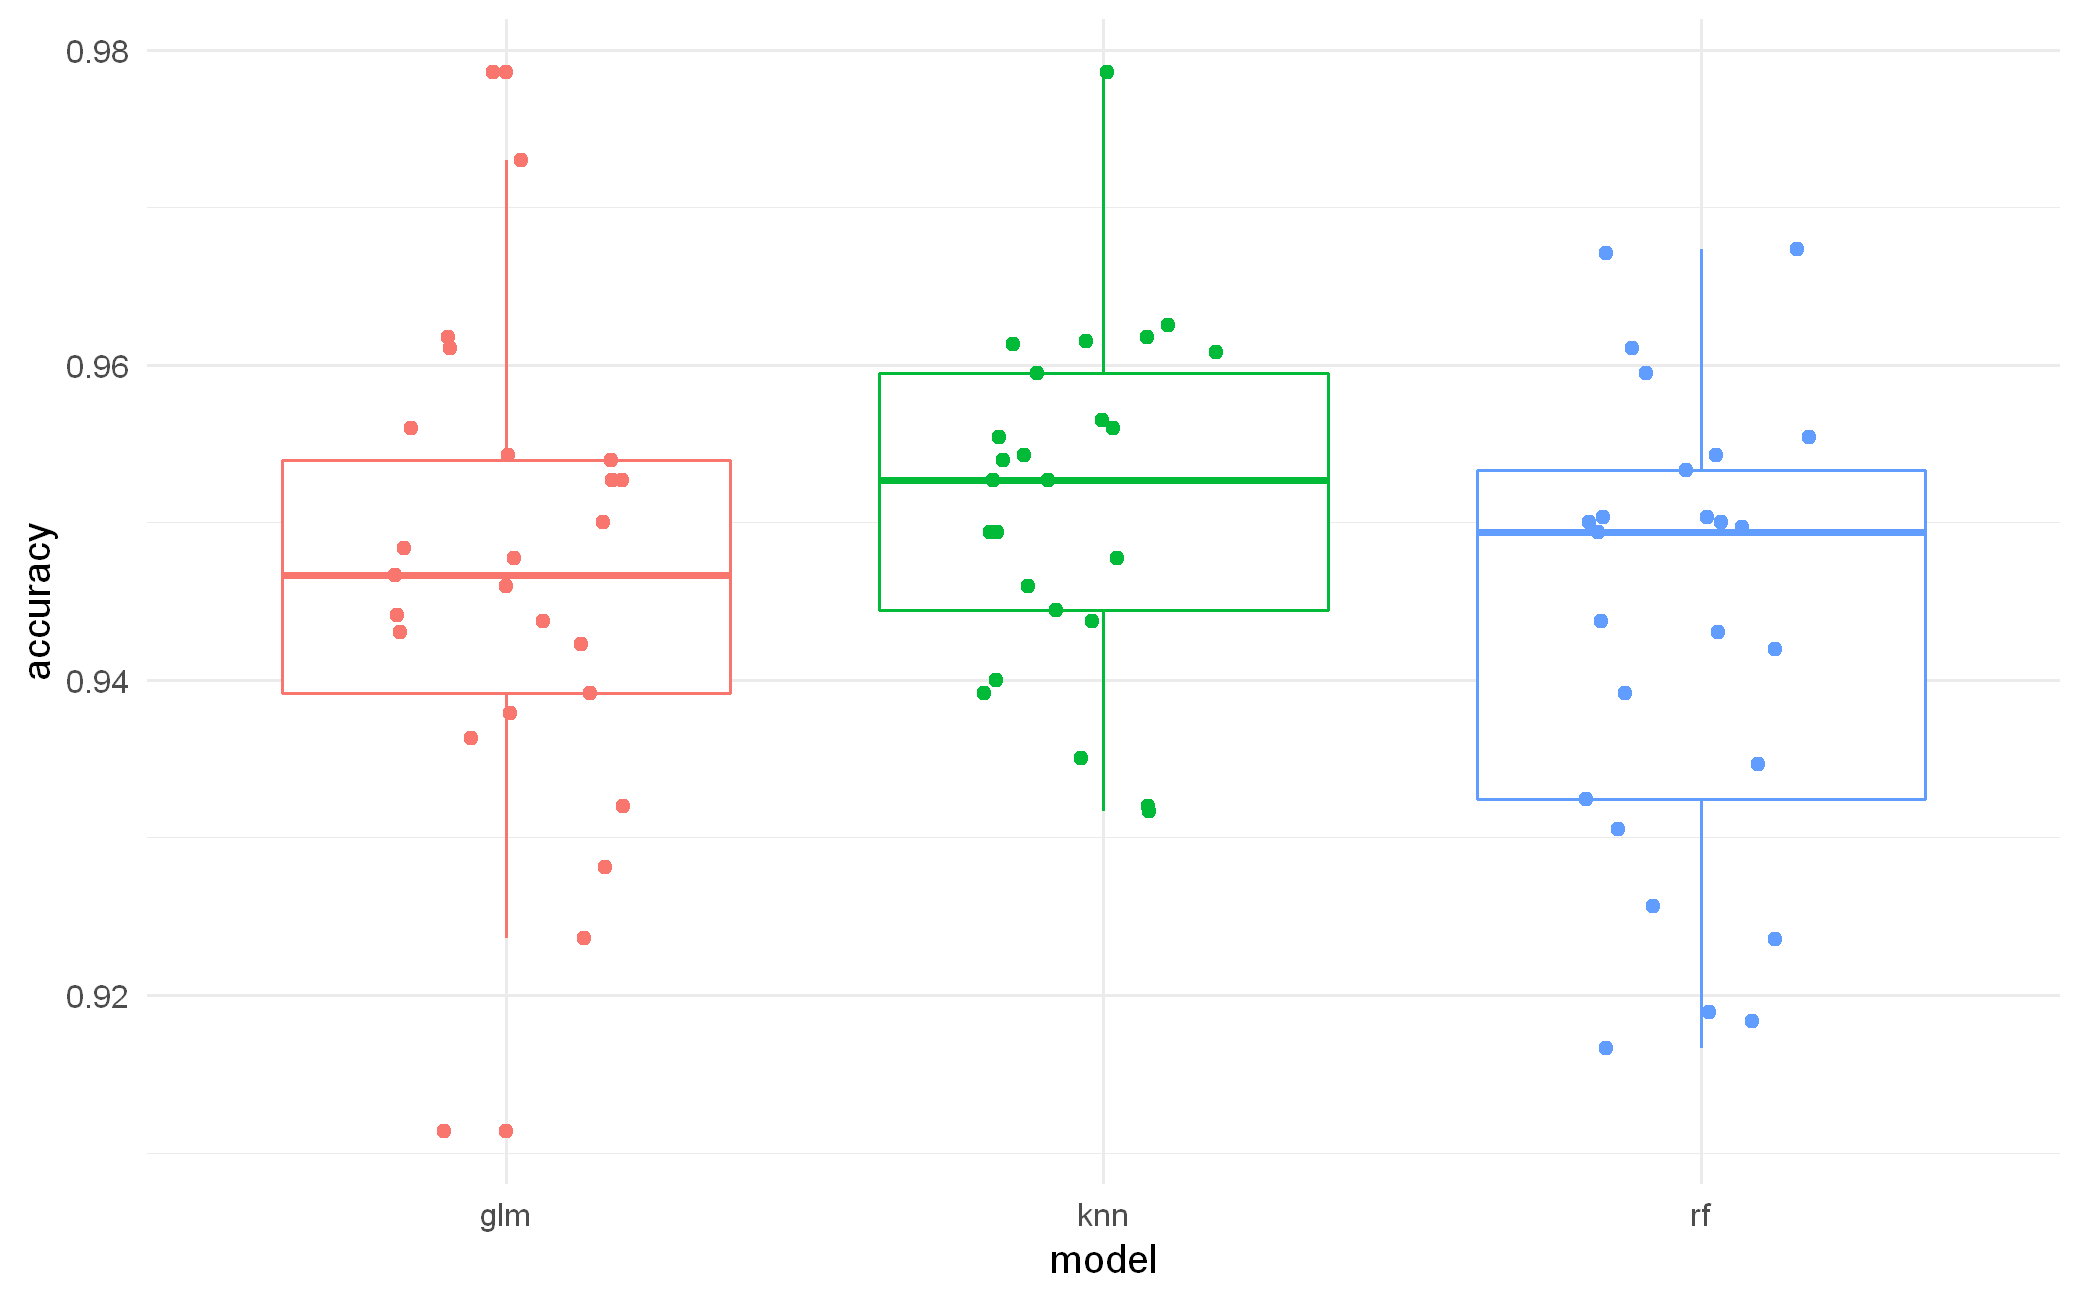

In [45]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res=260)

ggplot(bootstrap_results, aes(model, accuracy, color = model)) +
    geom_boxplot() + 
    geom_point(position = position_jitterdodge()) + 
    theme_minimal() + 
    theme(legend.position = "none")

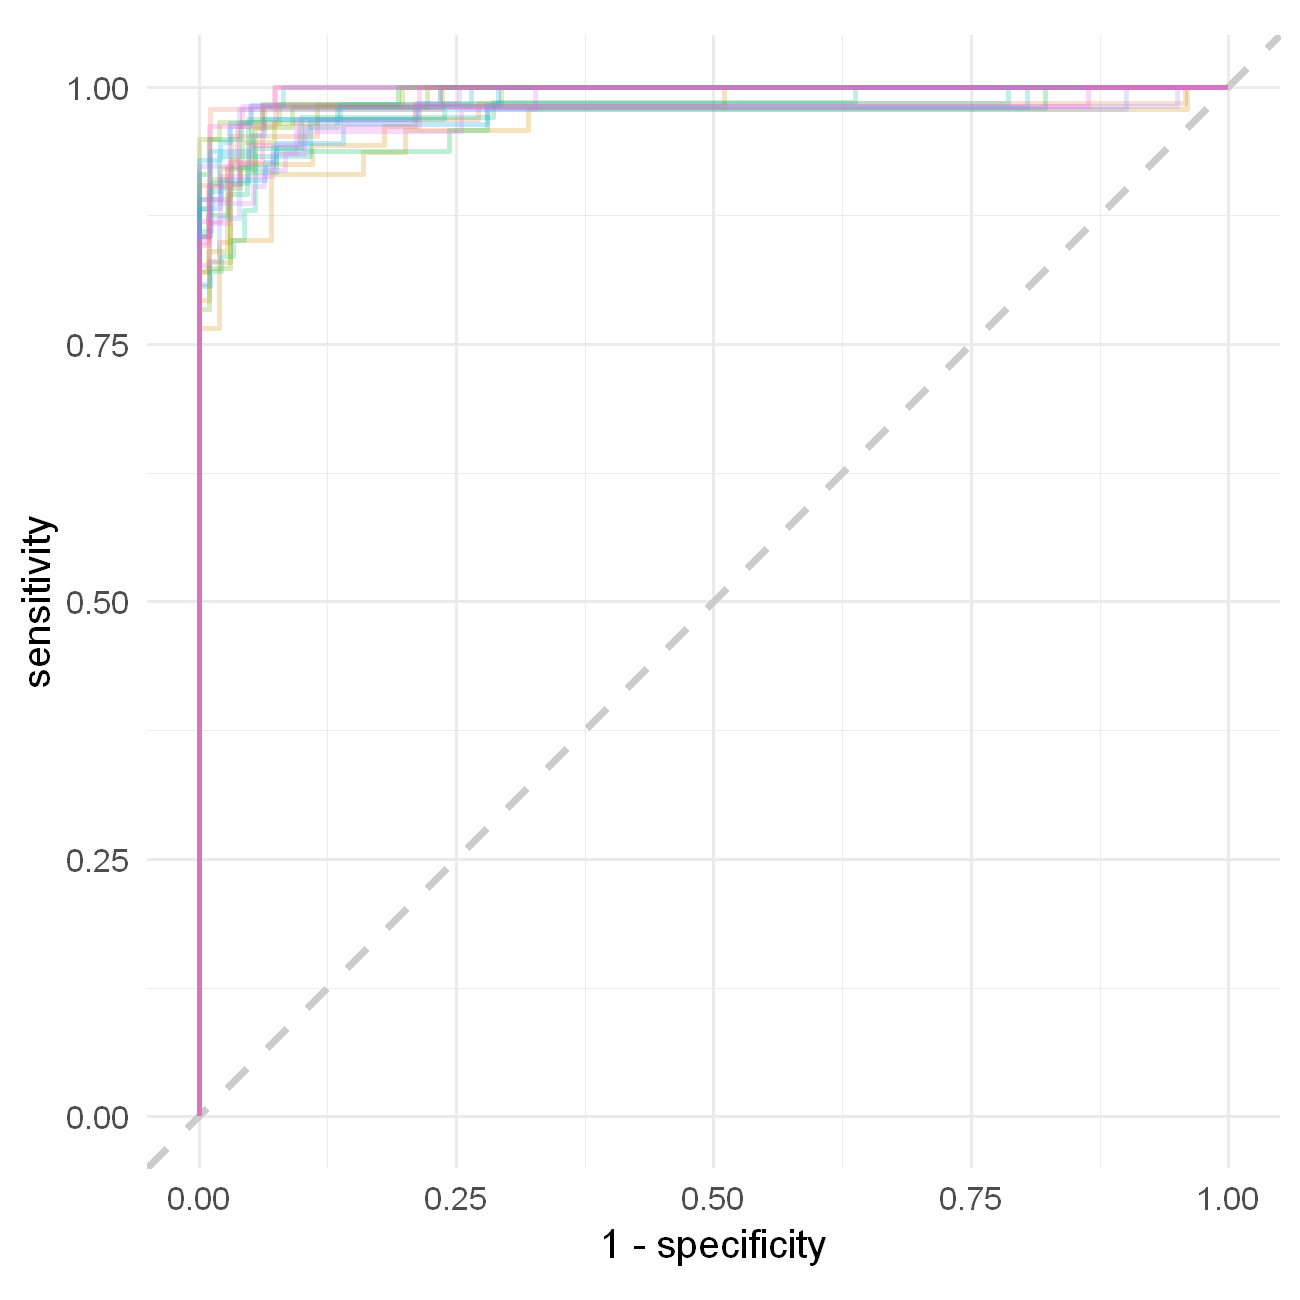

In [46]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res=260)
glm_results %>%
    collect_predictions() %>%
    group_by(id) %>%
    roc_curve(diagnosis, .pred_M) %>%
    ggplot(aes(1 - specificity, sensitivity, color = id)) + 
        geom_abline(lty = 2, color = "gray80", size = 1) + 
        geom_path(show.legend = FALSE, alpha = 0.25, size = 0.75) + 
        coord_equal() + 
        theme_minimal()

In [47]:
diagnosis_final_model <- diagnosis_workflow %>%
    add_model(model_alt_glm) %>%
    last_fit(data_split)

! train/test split: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...



In [48]:
collect_metrics(diagnosis_final_model)

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.9790210,Preprocessor1_Model1
roc_auc,binary,0.9975787,Preprocessor1_Model1


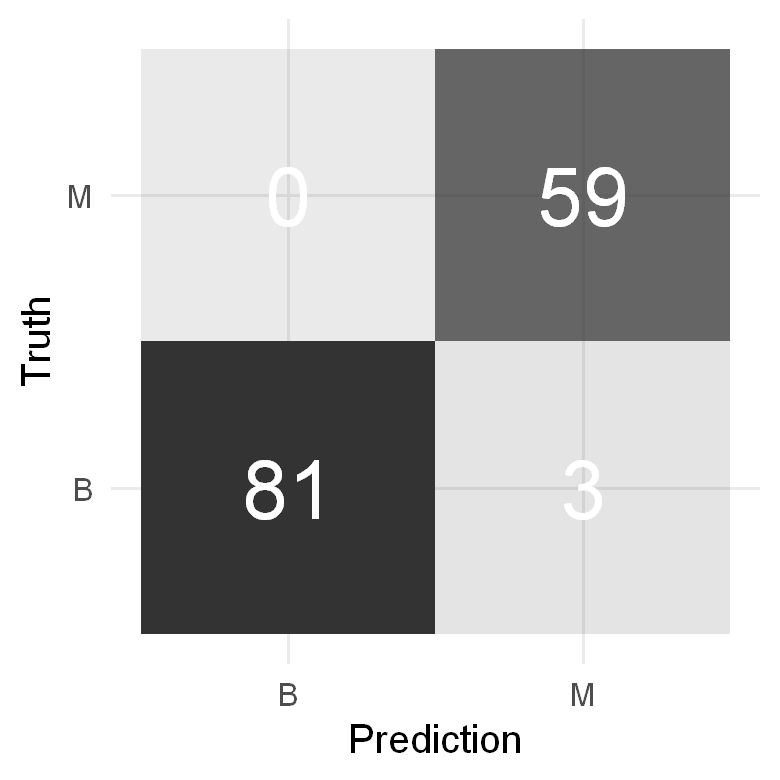

In [49]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=260)

collect_predictions(diagnosis_final_model) %>% 
    conf_mat(diagnosis, .pred_class) %>% 
    pluck(1) %>%
    as_tibble() %>%
    ggplot(aes(Prediction, Truth, alpha = n)) +
    geom_tile(show.legend = FALSE) +
    geom_text(aes(label = n), colour = "white", alpha = 1, size = 8) + 
    theme_minimal()

In [50]:
diagnosis_final_model$.workflow[[1]] %>%
    tidy(exponentiate = TRUE) %>%
    arrange(estimate)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
`\`concave points_mean\``,8.596639e-36,32.04571577,-2.5195784,0.01174955
`\`concave points_worst\``,1.473148e-09,12.17022485,-1.6709522,0.09473112
(Intercept),9.698246e-05,9.76523972,-0.9463137,0.34398859
perimeter_worst,8.995822e-01,0.12763054,-0.8291500,0.40701954
area_worst,9.767568e-01,0.01850127,-1.2711348,0.20368069
area_mean,9.798477e-01,0.02898595,-0.7023464,0.48246319
perimeter_mean,1.545720e+00,0.47202359,0.9226016,0.35621486
radius_mean,1.739465e+00,4.05050722,0.1366688,0.89129263
radius_worst,1.953578e+00,1.76326484,0.3797857,0.70410453
